# TODO:

*  Wrapper for reward clipping to [-1, 1] (same reason like image normalization)
* action repeat Wrapper (4 Times)
* better reward handling for different games
* Explanations
* Adding results to a Dataframe and save to hard drive (to compare with other models)

In [1]:
import gym
import numpy as np
from matplotlib import pyplot as plt

# **Auswahl des Spiels**

[Hier](https://gym.openai.com/envs/#atari) ist eine vollständige Liste der verfügbaren Spiele zu finden. Um ein Environment zu erstellen muss der vollständige Name des Spiels als String übergeben werden.

Beispiel:

```python
game = "MsPacman-v0"
```

In [2]:
# Hier kann das Spiel übergeben werden
game = "MsPacman-v0"

# **Preprocessing**
[Stable Baselines](https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py)


### Fire Wrapper

In [3]:
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env) 
        self.env.reset()

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        observation, _, _, _ = self.env.step(env.unwrapped.get_action_meanings().index('FIRE'))

        return observation

In [4]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info
    
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

In [5]:
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

In [6]:
class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

### Episodic Life Wrapper

In [7]:
class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

### Clip Reward Wrapper

In [8]:
class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

### Resize & Grayscale Wrapper

In [9]:
from gym import spaces
import cv2

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        :param env: (Gym Environment) the environment
        """
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255, shape=(self.height, self.width, 1),
                                            dtype=env.observation_space.dtype)
        
    def observation(self, frame):
        """
        returns the current observation from a frame
        :param frame: ([int] or [float]) environment frame
        :return: ([int] or [float]) the observation
        """
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

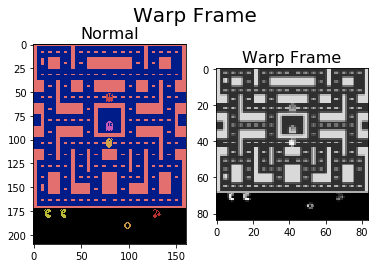

In [10]:
"""
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten
"""

def WarpFrameEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    return env

normal_env = gym.make(game)
wrapped_env = WarpFrameEnv(game)

normal_env.reset()
wrapped_env.reset()
action = normal_env.action_space.sample()

normal_state, _, _, _ = normal_env.step(action)
wrapped_state, _, _, _ = wrapped_env.step(action)

wrapped_state = wrapped_state[: , :, 0]

fig, axs = plt.subplots(1, 2)
fig.suptitle('Warp Frame', fontsize=20)
axs[0].imshow(normal_state)
axs[0].set_title("Normal", fontsize=16)
axs[1].imshow(wrapped_state, cmap="gray")
axs[1].set_title("Warp Frame", fontsize=16)
plt.show()

### Frame Stack Wrapper

In [11]:
from collections import deque

class FrameStack(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.frames = deque(maxlen=4)
        low = np.repeat(self.observation_space.low[np.newaxis, ...], repeats=4, axis=0)
        high = np.repeat(self.observation_space.high[np.newaxis, ...], repeats=4, axis=0)
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=self.observation_space.dtype)

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack, reward, done, info

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        for _ in range(4):
            self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack

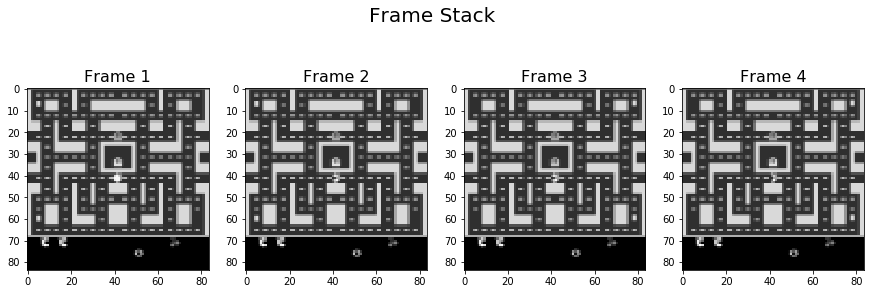

In [12]:
"""
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten
"""

def FrameStackEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = FrameStack(env)
    return env

env = FrameStackEnv(game)
env.reset()

for _ in range(1, 5):
  # Führe eine zufällige Aktion aus
  state, _, _, _ = env.step(env.action_space.sample())

# Stack umformen, damit das Plotten der vier Bilder gelingt
state = state.reshape(84, 84,4)

# Frame Stack plotten
fig, axs = plt.subplots(1,4, figsize=(15, 5))
fig.suptitle('Frame Stack', fontsize=20)
for i in range(state.shape[2]):
    axs[i].imshow(state[:, :, i], cmap="gray")
    axs[i].set_title("Frame "+str(i+1), fontsize=16)
    axs[i].axis("off")
plt.show()

### Erstellen des Environments

In [13]:
def make_env(env_name):
    env = gym.make(env_name)
    env = EpisodicLifeEnv(env)
    env = MaxAndSkipEnv(env)
    env = ScaledFloatFrame(env)
    env = NoopResetEnv(env)
    env = ClipRewardEnv(env)
    env = WarpFrame(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = FrameStack(env)
    return env

env = make_env(game)

# **Deep Q-Network und Target Network**

 *\"The input to
the neural network consists of an 84x84x4 image produced by the preprocessing
map **--w-- (falsche Darstellung)**. The first hidden layer convolves 32 filters of 8x8 with stride 4 with the
input image and applies a rectifier nonlinearity. The second hidden layer convolves
64 filters of 4x4 with stride 2, again followed by a rectifier nonlinearity.
This is followed by a third convolutional layer that convolves 64 filters of 333 with
stride 1 followed by a rectifier. The final hidden layer is fully-connected and consists
of 512 rectifier units. The output layer is a fully-connected linear layer with a
single output for each valid action. The number of valid actions varied between 4
and 18 on the games we considered."*


[Mnih, V., Kavukcuoglu, K., Silver, D. et al. Human-level control through deep reinforcement learning. Nature 518, 529–533 (2015).](https://www.nature.com/articles/nature14236)

In [14]:
import tensorflow as tf
"""
# Tell TF to not use all GPU RAM
config = tf.compat.v1.ConfigProto
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = .2
session = tf.Session(config=config)
"""
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import RMSprop, Adam

# DQN und Tagret Net Parameters
INPUT_SHAPE = (84, 84, 4) # (Höhe, Breite, Frames)
OUTPUT_SHAPE = env.action_space.n # Anzahl der möglichen Aktionen
LOSS_FUNCTION = "mean_squared_error"#Huber()################################################################### MSE probieren
OPTIMIZER = Adam(lr=0.00005)#RMSprop(learning_rate=0.00025, rho=0.95, epsilon=0.01) # Adam probieren mit 0.00005#############################

# Funktion zum erstellen eines neuronalen Netzes
def build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER):
    net_input = Input(shape=INPUT_SHAPE)
    x = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4), padding="same")(net_input)
    x = Activation("relu")(x)
    x = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same")(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
    x = Activation("relu")(x)
    x = Flatten()(x)
    x = Dense(512)(x)
    x = Activation("relu")(x)
    net_output = Dense(OUTPUT_SHAPE)(x)

    model = Model(inputs=net_input, outputs=net_output)
    model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER)

    return model

# Deep Q-Network
DQN = build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER)
# Target Network
TARGET = build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER)

In [15]:
DQN.summary()
TARGET.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 84, 84, 4)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 21, 21, 32)        8224      
_________________________________________________________________
activation (Activation)      (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        32832     
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 11, 11, 64)        0     

# **Memory Buffer**

In [16]:
MEMORY_SIZE = 25000#1000000
MEMORY_BUFFER = deque(maxlen=MEMORY_SIZE)
TRAIN_START = 32#50000

# Speichert Transition von einem State in einen Folgestate
def save_transition(state, action, reward, next_state, done):
    MEMORY_BUFFER.append([state, action, reward, next_state, done])

# **Experience Replay**

In [17]:
import random
MINIBATCH_SIZE = 32
GAMMA = 0.99

def replay():

    # Ziehe 32 (MINIBATCH_SIZE) zufällige Transitionen aus dem Buffer in einen Minibatch
    minibatch = random.sample(MEMORY_BUFFER, MINIBATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*minibatch)

    states = np.concatenate(states)
    next_states = np.concatenate(next_states)

    q_values = DQN.predict(states)
    q_values_next = TARGET.predict(next_states)

    # Q-Values Update
    for i in range(MINIBATCH_SIZE):
        a = actions[i]
        done = dones[i]
        if done:
            q_values[i][a] = rewards[i]
        else:
            q_values[i][a] = rewards[i] + GAMMA * np.max(q_values_next[i])

    DQN.fit(states, q_values, batch_size=MINIBATCH_SIZE, verbose=0)

# **Aktion wählen**
Exploration & Exploitation

In [18]:
def linear(epsilon, decay, epsilon_min, decay_step):
    return epsilon - decay

def exponential(epsilon, decay, epsilon_min, decay_step):
    epsilon = 1
    return epsilon_min + (epsilon - epsilon_min) * np.exp(-decay * decay_step)

def epsilon_decay(mode, epsilon, decay, epsilon_min, decay_step):
    decay_strategy = {
        "linear": linear,
        "exponential": exponential
    }
    strategy = decay_strategy.get(mode)
    return strategy(epsilon, decay, epsilon_min, decay_step)

In [19]:
EPSILON = 1.0
EPSILON_MIN = 0.02 #0.1
#EPSILON_STEPS = 1000000
EPSILON_DECAY = 0.00002 #0.0000009

def get_action(state):
    if np.random.rand() <= EPSILON:
        return np.random.randint(env.action_space.n)
    else:
        return np.argmax(DQN(state))

In [20]:
# Initial Mean Reward -> Mean Reward kann nich auf 0 gesetzt werden (Pong -21)
INITIAL_MEAN_REWARD = 0.0
env.reset()
while True:
    _, reward, done, _ = env.step(env.action_space.sample())
    INITIAL_MEAN_REWARD += reward
    if done:
        break
INITIAL_MEAN_REWARD

9.0

# **Training des Agenten**

In [21]:
from datetime import datetime
start_time = datetime.now()

EPISODES = 15000
REWARD_LIST = []
MEAN_LIST = []
BEST_MEAN_REWARD = INITIAL_MEAN_REWARD
EPSILON_LIST = []
STEPS = 0
SYNC = 1000 #10000

for episode in range(EPISODES):
    EPISODE_REWARD = 0.0
    state = env.reset()
    done = False
    
    while not done:
        action = get_action(state)
        next_state, reward, done, _ = env.step(action)
        
        # Transition im MEMORY BUFFER speichern
        save_transition(state, action, reward, next_state, done)
        
        # Experience Replay, falls genügend Transitionen gespeichert
        if len(MEMORY_BUFFER) > TRAIN_START:
            replay()
            
        # Synchronisation zwischen Target Networks und Deep Q-Network (alle 1000 Updates - Algorithm 1)
        if STEPS % SYNC == 0:
            TARGET.set_weights(DQN.get_weights())

        # Reward einer Aktion zum gesamten Reward der Episode addieren
        EPISODE_REWARD += reward
        
        # State aktualisieren
        state = next_state
        STEPS += 1
        
        # EPSILON verringern
        if EPSILON > EPSILON_MIN:
            EPSILON = epsilon_decay("exponential", EPSILON, EPSILON_DECAY, EPSILON_MIN, STEPS)

        if done:
            REWARD_LIST.append(EPISODE_REWARD)
            current_mean_reward = np.mean(REWARD_LIST[-min(len(REWARD_LIST), 10):])
            MEAN_LIST.append(np.mean(REWARD_LIST))
            
            EPSILON_LIST.append(EPSILON)
            print("Episode:", episode+1, "\tReward:", EPISODE_REWARD, "\tMean:", round(current_mean_reward, 2),"\tBestMean:", BEST_MEAN_REWARD, "\tTRAIN START:", (len(MEMORY_BUFFER)>TRAIN_START), "\tEpsi:", EPSILON)

            # Übernahme des höchsteb Mean Rewards
            if current_mean_reward > BEST_MEAN_REWARD:
                BEST_MEAN_REWARD = current_mean_reward
        
                # Trainierte Gewichte speichern
                if EPSILON < 0.3:
                    import os
                    PATH = "WEIGHTS"
                    try:
                        os.makedirs(PATH)
                    except FileExistsError:
                        # Pfad existiert bereits
                        pass
                    DQN.save_weights(PATH +"/" + game + "_DQN"+ "_Ep_"+ str(episode+1)+ ".h5")
                    #TARGET.save_weights(PATH+"/" + game + "_TARGET" + "_Ep_"+ str(episode+1)+ ".h5")
                    
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Episode: 1 	Reward: 0.0 	Mean: 0.0 	BestMean: 9.0 	TRAIN START: False 	Epsi: 0.9998236158750475
Episode: 2 	Reward: 5.0 	Mean: 2.5 	BestMean: 9.0 	TRAIN START: False 	Epsi: 0.9994905324730371


W0107 11:54:41.374895 140302601176896 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:466: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Episode: 3 	Reward: 15.0 	Mean: 6.67 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.9987464024735748
Episode: 4 	Reward: 10.0 	Mean: 7.5 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.9977877008396794
Episode: 5 	Reward: 18.0 	Mean: 9.6 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.9956584453835521
Episode: 6 	Reward: 8.0 	Mean: 9.33 	BestMean: 9.6 	TRAIN START: True 	Epsi: 0.9949172266638514
Episode: 7 	Reward: 28.0 	Mean: 12.0 	BestMean: 9.6 	TRAIN START: True 	Epsi: 0.9930082602977527
Episode: 8 	Reward: 1.0 	Mean: 10.62 	BestMean: 12.0 	TRAIN START: True 	Epsi: 0.9925996826357428
Episode: 9 	Reward: 9.0 	Mean: 10.44 	BestMean: 12.0 	TRAIN START: True 	Epsi: 0.9918802251027109
Episode: 10 	Reward: 7.0 	Mean: 10.1 	BestMean: 12.0 	TRAIN START: True 	Epsi: 0.9912001470002447
Episode: 11 	Reward: 3.0 	Mean: 10.4 	BestMean: 12.0 	TRAIN START: True 	Epsi: 0.9908311610561541
Episode: 12 	Reward: 5.0 	Mean: 10.4 	BestMean: 12.0 	TRAIN START: True 	Epsi: 0.9901712202719323
Episode: 13 	Reward: 13.0 	M

Episode: 87 	Reward: 6.0 	Mean: 6.7 	BestMean: 14.9 	TRAIN START: True 	Epsi: 0.9259395406705846
Episode: 88 	Reward: 15.0 	Mean: 8.2 	BestMean: 14.9 	TRAIN START: True 	Epsi: 0.9250340539487322
Episode: 89 	Reward: 35.0 	Mean: 11.2 	BestMean: 14.9 	TRAIN START: True 	Epsi: 0.9229729268834636
Episode: 90 	Reward: 5.0 	Mean: 10.5 	BestMean: 14.9 	TRAIN START: True 	Epsi: 0.9221425738117114
Episode: 91 	Reward: 14.0 	Mean: 11.2 	BestMean: 14.9 	TRAIN START: True 	Epsi: 0.9212769325151557
Episode: 92 	Reward: 9.0 	Mean: 10.9 	BestMean: 14.9 	TRAIN START: True 	Epsi: 0.9206822859946332
Episode: 93 	Reward: 26.0 	Mean: 13.5 	BestMean: 14.9 	TRAIN START: True 	Epsi: 0.9187568868145238
Episode: 94 	Reward: 14.0 	Mean: 13.8 	BestMean: 14.9 	TRAIN START: True 	Epsi: 0.9179304107159539
Episode: 95 	Reward: 0.0 	Mean: 12.7 	BestMean: 14.9 	TRAIN START: True 	Epsi: 0.917499507543845
Episode: 96 	Reward: 12.0 	Mean: 13.6 	BestMean: 14.9 	TRAIN START: True 	Epsi: 0.9165486621029629
Episode: 97 	Rewa

Episode: 170 	Reward: 11.0 	Mean: 10.6 	BestMean: 18.0 	TRAIN START: True 	Epsi: 0.8599585720765216
Episode: 171 	Reward: 14.0 	Mean: 10.8 	BestMean: 18.0 	TRAIN START: True 	Epsi: 0.8594379591685125
Episode: 172 	Reward: 2.0 	Mean: 10.2 	BestMean: 18.0 	TRAIN START: True 	Epsi: 0.8590686877121564
Episode: 173 	Reward: 10.0 	Mean: 10.0 	BestMean: 18.0 	TRAIN START: True 	Epsi: 0.8584480065635981
Episode: 174 	Reward: 5.0 	Mean: 8.5 	BestMean: 18.0 	TRAIN START: True 	Epsi: 0.8579115715169227
Episode: 175 	Reward: 32.0 	Mean: 10.9 	BestMean: 18.0 	TRAIN START: True 	Epsi: 0.8561370806102737
Episode: 176 	Reward: 10.0 	Mean: 11.9 	BestMean: 18.0 	TRAIN START: True 	Epsi: 0.8552846555987124
Episode: 177 	Reward: 11.0 	Mean: 11.9 	BestMean: 18.0 	TRAIN START: True 	Epsi: 0.8548337236472736
Episode: 178 	Reward: 22.0 	Mean: 11.7 	BestMean: 18.0 	TRAIN START: True 	Epsi: 0.8540493486610449
Episode: 179 	Reward: 11.0 	Mean: 12.8 	BestMean: 18.0 	TRAIN START: True 	Epsi: 0.8532657106408749
Epi

Episode: 253 	Reward: 17.0 	Mean: 10.0 	BestMean: 18.0 	TRAIN START: True 	Epsi: 0.79465097390788
Episode: 254 	Reward: 12.0 	Mean: 10.5 	BestMean: 18.0 	TRAIN START: True 	Epsi: 0.7941708391612088
Episode: 255 	Reward: 16.0 	Mean: 10.5 	BestMean: 18.0 	TRAIN START: True 	Epsi: 0.7934434604939302
Episode: 256 	Reward: 2.0 	Mean: 9.9 	BestMean: 18.0 	TRAIN START: True 	Epsi: 0.7930259137730246
Episode: 257 	Reward: 16.0 	Mean: 11.1 	BestMean: 18.0 	TRAIN START: True 	Epsi: 0.7923305034322223
Episode: 258 	Reward: 6.0 	Mean: 10.0 	BestMean: 18.0 	TRAIN START: True 	Epsi: 0.791589421924966
Episode: 259 	Reward: 2.0 	Mean: 9.4 	BestMean: 18.0 	TRAIN START: True 	Epsi: 0.7914042626837017
Episode: 260 	Reward: 14.0 	Mean: 10.8 	BestMean: 18.0 	TRAIN START: True 	Epsi: 0.7907719704635408
Episode: 261 	Reward: 25.0 	Mean: 11.6 	BestMean: 18.0 	TRAIN START: True 	Epsi: 0.7893242804141087
Episode: 262 	Reward: 0.0 	Mean: 11.0 	BestMean: 18.0 	TRAIN START: True 	Epsi: 0.7892165825538768
Episode: 

Episode: 336 	Reward: 14.0 	Mean: 10.4 	BestMean: 18.6 	TRAIN START: True 	Epsi: 0.7397994068992153
Episode: 337 	Reward: 15.0 	Mean: 11.1 	BestMean: 18.6 	TRAIN START: True 	Epsi: 0.7390080628706357
Episode: 338 	Reward: 13.0 	Mean: 10.9 	BestMean: 18.6 	TRAIN START: True 	Epsi: 0.7382750485473648
Episode: 339 	Reward: 11.0 	Mean: 10.0 	BestMean: 18.6 	TRAIN START: True 	Epsi: 0.737700658295262
Episode: 340 	Reward: 15.0 	Mean: 11.5 	BestMean: 18.6 	TRAIN START: True 	Epsi: 0.7370980428762037
Episode: 341 	Reward: 4.0 	Mean: 10.2 	BestMean: 18.6 	TRAIN START: True 	Epsi: 0.7368686082139871
Episode: 342 	Reward: 12.0 	Mean: 10.8 	BestMean: 18.6 	TRAIN START: True 	Epsi: 0.7362093923802104
Episode: 343 	Reward: 17.0 	Mean: 12.4 	BestMean: 18.6 	TRAIN START: True 	Epsi: 0.7356652800308842
Episode: 344 	Reward: 2.0 	Mean: 11.2 	BestMean: 18.6 	TRAIN START: True 	Epsi: 0.735307536834121
Episode: 345 	Reward: 20.0 	Mean: 12.3 	BestMean: 18.6 	TRAIN START: True 	Epsi: 0.7344068169104271
Epis

Episode: 419 	Reward: 20.0 	Mean: 9.2 	BestMean: 19.7 	TRAIN START: True 	Epsi: 0.6757847247951203
Episode: 420 	Reward: 0.0 	Mean: 8.6 	BestMean: 19.7 	TRAIN START: True 	Epsi: 0.675706035349606
Episode: 421 	Reward: 1.0 	Mean: 7.7 	BestMean: 19.7 	TRAIN START: True 	Epsi: 0.6751423705698013
Episode: 422 	Reward: 11.0 	Mean: 8.6 	BestMean: 19.7 	TRAIN START: True 	Epsi: 0.67478868919226
Episode: 423 	Reward: 13.0 	Mean: 8.7 	BestMean: 19.7 	TRAIN START: True 	Epsi: 0.6743435842364456
Episode: 424 	Reward: 0.0 	Mean: 7.7 	BestMean: 19.7 	TRAIN START: True 	Epsi: 0.6741996444818671
Episode: 425 	Reward: 17.0 	Mean: 7.5 	BestMean: 19.7 	TRAIN START: True 	Epsi: 0.6735849857509171
Episode: 426 	Reward: 0.0 	Mean: 6.6 	BestMean: 19.7 	TRAIN START: True 	Epsi: 0.6734150757438799
Episode: 427 	Reward: 0.0 	Mean: 6.6 	BestMean: 19.7 	TRAIN START: True 	Epsi: 0.6733105376950279
Episode: 428 	Reward: 30.0 	Mean: 9.2 	BestMean: 19.7 	TRAIN START: True 	Epsi: 0.6719921823960205
Episode: 429 	Rewa

Episode: 502 	Reward: 6.0 	Mean: 19.8 	BestMean: 23.1 	TRAIN START: True 	Epsi: 0.621599879095851
Episode: 503 	Reward: 19.0 	Mean: 20.3 	BestMean: 23.1 	TRAIN START: True 	Epsi: 0.6207221841455927
Episode: 504 	Reward: 25.0 	Mean: 19.9 	BestMean: 23.1 	TRAIN START: True 	Epsi: 0.6195219404211072
Episode: 505 	Reward: 6.0 	Mean: 19.3 	BestMean: 23.1 	TRAIN START: True 	Epsi: 0.6188268981726602
Episode: 506 	Reward: 13.0 	Mean: 18.3 	BestMean: 23.1 	TRAIN START: True 	Epsi: 0.6181446244786392
Episode: 507 	Reward: 17.0 	Mean: 19.6 	BestMean: 23.1 	TRAIN START: True 	Epsi: 0.6172241906728809
Episode: 508 	Reward: 6.0 	Mean: 17.7 	BestMean: 23.1 	TRAIN START: True 	Epsi: 0.6167227329944264
Episode: 509 	Reward: 43.0 	Mean: 21.1 	BestMean: 23.1 	TRAIN START: True 	Epsi: 0.6156257726786961
Episode: 510 	Reward: 20.0 	Mean: 22.0 	BestMean: 23.1 	TRAIN START: True 	Epsi: 0.6148876544484548
Episode: 511 	Reward: 17.0 	Mean: 17.2 	BestMean: 23.1 	TRAIN START: True 	Epsi: 0.6143406094856301
Epis

Episode: 585 	Reward: 5.0 	Mean: 11.0 	BestMean: 23.1 	TRAIN START: True 	Epsi: 0.5738825007063297
Episode: 586 	Reward: 4.0 	Mean: 10.7 	BestMean: 23.1 	TRAIN START: True 	Epsi: 0.5734949186253898
Episode: 587 	Reward: 16.0 	Mean: 11.3 	BestMean: 23.1 	TRAIN START: True 	Epsi: 0.5729748778593342
Episode: 588 	Reward: 16.0 	Mean: 12.2 	BestMean: 23.1 	TRAIN START: True 	Epsi: 0.5724553257019169
Episode: 589 	Reward: 10.0 	Mean: 11.8 	BestMean: 23.1 	TRAIN START: True 	Epsi: 0.5720687422939038
Episode: 590 	Reward: 15.0 	Mean: 13.1 	BestMean: 23.1 	TRAIN START: True 	Epsi: 0.5716382965705703
Episode: 591 	Reward: 11.0 	Mean: 11.5 	BestMean: 23.1 	TRAIN START: True 	Epsi: 0.5712963868296688
Episode: 592 	Reward: 12.0 	Mean: 10.6 	BestMean: 23.1 	TRAIN START: True 	Epsi: 0.570976727635435
Episode: 593 	Reward: 11.0 	Mean: 11.7 	BestMean: 23.1 	TRAIN START: True 	Epsi: 0.5705251119065282
Episode: 594 	Reward: 3.0 	Mean: 10.3 	BestMean: 23.1 	TRAIN START: True 	Epsi: 0.570029862201609
Episo

Episode: 668 	Reward: 10.0 	Mean: 12.6 	BestMean: 24.1 	TRAIN START: True 	Epsi: 0.5288292871870451
Episode: 669 	Reward: 18.0 	Mean: 11.9 	BestMean: 24.1 	TRAIN START: True 	Epsi: 0.5283003798078799
Episode: 670 	Reward: 7.0 	Mean: 10.6 	BestMean: 24.1 	TRAIN START: True 	Epsi: 0.5281174246050615
Episode: 671 	Reward: 7.0 	Mean: 8.7 	BestMean: 24.1 	TRAIN START: True 	Epsi: 0.5278329585052246
Episode: 672 	Reward: 19.0 	Mean: 10.4 	BestMean: 24.1 	TRAIN START: True 	Epsi: 0.5272442138112989
Episode: 673 	Reward: 22.0 	Mean: 10.8 	BestMean: 24.1 	TRAIN START: True 	Epsi: 0.5264231434315003
Episode: 674 	Reward: 9.0 	Mean: 11.4 	BestMean: 24.1 	TRAIN START: True 	Epsi: 0.5259878067497537
Episode: 675 	Reward: 14.0 	Mean: 12.8 	BestMean: 24.1 	TRAIN START: True 	Epsi: 0.5256236266494626
Episode: 676 	Reward: 11.0 	Mean: 12.7 	BestMean: 24.1 	TRAIN START: True 	Epsi: 0.5249869420753993
Episode: 677 	Reward: 0.0 	Mean: 11.7 	BestMean: 24.1 	TRAIN START: True 	Epsi: 0.524774892093341
Episod

Episode: 751 	Reward: 2.0 	Mean: 15.4 	BestMean: 24.1 	TRAIN START: True 	Epsi: 0.4852861402287839
Episode: 752 	Reward: 29.0 	Mean: 17.0 	BestMean: 24.1 	TRAIN START: True 	Epsi: 0.48470024888115804
Episode: 753 	Reward: 18.0 	Mean: 17.4 	BestMean: 24.1 	TRAIN START: True 	Epsi: 0.48432863734648623
Episode: 754 	Reward: 1.0 	Mean: 14.8 	BestMean: 24.1 	TRAIN START: True 	Epsi: 0.48422649628219905
Episode: 755 	Reward: 15.0 	Mean: 15.7 	BestMean: 24.1 	TRAIN START: True 	Epsi: 0.4836512121766676
Episode: 756 	Reward: 36.0 	Mean: 19.3 	BestMean: 24.1 	TRAIN START: True 	Epsi: 0.48228083374925607
Episode: 757 	Reward: 8.0 	Mean: 18.2 	BestMean: 24.1 	TRAIN START: True 	Epsi: 0.4819943084643482
Episode: 758 	Reward: 36.0 	Mean: 21.8 	BestMean: 24.1 	TRAIN START: True 	Epsi: 0.480803899436476
Episode: 759 	Reward: 19.0 	Mean: 22.2 	BestMean: 24.1 	TRAIN START: True 	Epsi: 0.4800580014598778
Episode: 760 	Reward: 0.0 	Mean: 16.4 	BestMean: 24.1 	TRAIN START: True 	Epsi: 0.4795430249389267
E

Episode: 833 	Reward: 2.0 	Mean: 13.9 	BestMean: 24.1 	TRAIN START: True 	Epsi: 0.44343184636651006
Episode: 834 	Reward: 8.0 	Mean: 13.2 	BestMean: 24.1 	TRAIN START: True 	Epsi: 0.44309323635148207
Episode: 835 	Reward: 13.0 	Mean: 14.2 	BestMean: 24.1 	TRAIN START: True 	Epsi: 0.4426196371918047
Episode: 836 	Reward: 9.0 	Mean: 13.4 	BestMean: 24.1 	TRAIN START: True 	Epsi: 0.4423323535260307
Episode: 837 	Reward: 9.0 	Mean: 12.5 	BestMean: 24.1 	TRAIN START: True 	Epsi: 0.44193554764169996
Episode: 838 	Reward: 10.0 	Mean: 11.8 	BestMean: 24.1 	TRAIN START: True 	Epsi: 0.44159813418696386
Episode: 839 	Reward: 28.0 	Mean: 13.3 	BestMean: 24.1 	TRAIN START: True 	Epsi: 0.44066322446283
Episode: 840 	Reward: 9.0 	Mean: 11.8 	BestMean: 24.1 	TRAIN START: True 	Epsi: 0.44021755769001825
Episode: 841 	Reward: 19.0 	Mean: 13.7 	BestMean: 24.1 	TRAIN START: True 	Epsi: 0.43972199341236984
Episode: 842 	Reward: 21.0 	Mean: 12.8 	BestMean: 24.1 	TRAIN START: True 	Epsi: 0.43892527874350007


Episode: 915 	Reward: 27.0 	Mean: 21.0 	BestMean: 24.5 	TRAIN START: True 	Epsi: 0.4075839892134591
Episode: 916 	Reward: 12.0 	Mean: 15.7 	BestMean: 24.5 	TRAIN START: True 	Epsi: 0.4073282681778027
Episode: 917 	Reward: 8.0 	Mean: 14.6 	BestMean: 24.5 	TRAIN START: True 	Epsi: 0.406964350673739
Episode: 918 	Reward: 31.0 	Mean: 17.7 	BestMean: 24.5 	TRAIN START: True 	Epsi: 0.4062066433421707
Episode: 919 	Reward: 7.0 	Mean: 16.8 	BestMean: 24.5 	TRAIN START: True 	Epsi: 0.4058978015806732
Episode: 920 	Reward: 3.0 	Mean: 16.8 	BestMean: 24.5 	TRAIN START: True 	Epsi: 0.40558149508676317
Episode: 921 	Reward: 19.0 	Mean: 17.4 	BestMean: 24.5 	TRAIN START: True 	Epsi: 0.4052269232393423
Episode: 922 	Reward: 17.0 	Mean: 17.0 	BestMean: 24.5 	TRAIN START: True 	Epsi: 0.4049034684938335
Episode: 923 	Reward: 15.0 	Mean: 17.2 	BestMean: 24.5 	TRAIN START: True 	Epsi: 0.4044649285550096
Episode: 924 	Reward: 9.0 	Mean: 14.8 	BestMean: 24.5 	TRAIN START: True 	Epsi: 0.40404224964961716
Epi

Episode: 997 	Reward: 14.0 	Mean: 13.7 	BestMean: 27.9 	TRAIN START: True 	Epsi: 0.3721061074047892
Episode: 998 	Reward: 14.0 	Mean: 14.9 	BestMean: 27.9 	TRAIN START: True 	Epsi: 0.3718456452681859
Episode: 999 	Reward: 12.0 	Mean: 16.1 	BestMean: 27.9 	TRAIN START: True 	Epsi: 0.3716346012005767
Episode: 1000 	Reward: 24.0 	Mean: 16.1 	BestMean: 27.9 	TRAIN START: True 	Epsi: 0.3709881884165035
Episode: 1001 	Reward: 46.0 	Mean: 18.7 	BestMean: 27.9 	TRAIN START: True 	Epsi: 0.37027290235198085
Episode: 1002 	Reward: 8.0 	Mean: 18.4 	BestMean: 27.9 	TRAIN START: True 	Epsi: 0.37004179850908575
Episode: 1003 	Reward: 26.0 	Mean: 20.1 	BestMean: 27.9 	TRAIN START: True 	Epsi: 0.3695730566262845
Episode: 1004 	Reward: 24.0 	Mean: 21.1 	BestMean: 27.9 	TRAIN START: True 	Epsi: 0.3691747704080093
Episode: 1005 	Reward: 24.0 	Mean: 20.8 	BestMean: 27.9 	TRAIN START: True 	Epsi: 0.3685537921512905
Episode: 1006 	Reward: 23.0 	Mean: 21.5 	BestMean: 27.9 	TRAIN START: True 	Epsi: 0.368233270

Episode: 1079 	Reward: 4.0 	Mean: 19.7 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.33919831018807006
Episode: 1080 	Reward: 18.0 	Mean: 20.3 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.33891753923244416
Episode: 1081 	Reward: 9.0 	Mean: 16.7 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.3384204157283913
Episode: 1082 	Reward: 14.0 	Mean: 16.6 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.3382166918609166
Episode: 1083 	Reward: 13.0 	Mean: 17.4 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.33798765830475125
Episode: 1084 	Reward: 46.0 	Mean: 18.8 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.33738405535835514
Episode: 1085 	Reward: 2.0 	Mean: 17.4 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.3370668299421403
Episode: 1086 	Reward: 8.0 	Mean: 15.5 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.3369146743840234
Episode: 1087 	Reward: 16.0 	Mean: 14.9 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.33661691455914516
Episode: 1088 	Reward: 5.0 	Mean: 13.5 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.3363763

Episode: 1161 	Reward: 18.0 	Mean: 23.0 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.3105549083443033
Episode: 1162 	Reward: 29.0 	Mean: 23.1 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.3102064515701695
Episode: 1163 	Reward: 51.0 	Mean: 26.0 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.30947605200219575
Episode: 1164 	Reward: 5.0 	Mean: 22.6 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.3092561337821831
Episode: 1165 	Reward: 27.0 	Mean: 25.0 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.3086897470003354
Episode: 1166 	Reward: 0.0 	Mean: 19.4 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.3086781996414042
Episode: 1167 	Reward: 1.0 	Mean: 16.7 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.30859160917073175
Episode: 1168 	Reward: 22.0 	Mean: 18.9 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.3083492940056458
Episode: 1169 	Reward: 3.0 	Mean: 17.5 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.30806685011763035
Episode: 1170 	Reward: 32.0 	Mean: 18.8 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.30737057

Episode: 1243 	Reward: 4.0 	Mean: 13.5 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.28623318807896464
Episode: 1244 	Reward: 20.0 	Mean: 15.0 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.28589262760342576
Episode: 1245 	Reward: 10.0 	Mean: 14.3 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.28564280596804237
Episode: 1246 	Reward: 7.0 	Mean: 10.0 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.2854516119858385
Episode: 1247 	Reward: 49.0 	Mean: 13.3 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.2845823570559259
Episode: 1248 	Reward: 9.0 	Mean: 12.7 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.28425447826004224
Episode: 1249 	Reward: 14.0 	Mean: 13.7 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.2840959731293805
Episode: 1250 	Reward: 52.0 	Mean: 18.7 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.28345763357679704
Episode: 1251 	Reward: 0.0 	Mean: 16.7 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.2832206283749166
Episode: 1252 	Reward: 13.0 	Mean: 17.8 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.282968

Episode: 1325 	Reward: 3.0 	Mean: 14.3 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.2629103807127733
Episode: 1326 	Reward: 42.0 	Mean: 18.5 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.26234748184468554
Episode: 1327 	Reward: 0.0 	Mean: 15.9 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.2623184018916962
Episode: 1328 	Reward: 10.0 	Mean: 16.8 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.26216336773070886
Episode: 1329 	Reward: 17.0 	Mean: 15.7 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.2619406798845128
Episode: 1330 	Reward: 20.0 	Mean: 15.8 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.26158287252104445
Episode: 1331 	Reward: 4.0 	Mean: 15.4 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.26115806060954766
Episode: 1332 	Reward: 28.0 	Mean: 17.2 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.2606858537246693
Episode: 1333 	Reward: 43.0 	Mean: 20.4 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.2599936756807589
Episode: 1334 	Reward: 16.0 	Mean: 18.3 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.259739

Episode: 1406 	Reward: 3.0 	Mean: 20.5 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.24092705334405398
Episode: 1407 	Reward: 56.0 	Mean: 22.6 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.24029610465818643
Episode: 1408 	Reward: 3.0 	Mean: 21.4 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.24021240804178057
Episode: 1409 	Reward: 8.0 	Mean: 21.7 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.23995271065188487
Episode: 1410 	Reward: 20.0 	Mean: 21.6 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.23980758975801744
Episode: 1411 	Reward: 8.0 	Mean: 20.6 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.23968892570172684
Episode: 1412 	Reward: 7.0 	Mean: 20.3 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.23948690483392965
Episode: 1413 	Reward: 8.0 	Mean: 17.3 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.23934209127047196
Episode: 1414 	Reward: 17.0 	Mean: 14.3 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.23914915513450458
Episode: 1415 	Reward: 17.0 	Mean: 14.7 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.2390

Episode: 1487 	Reward: 19.0 	Mean: 16.8 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.22205755279847567
Episode: 1488 	Reward: 14.0 	Mean: 17.0 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.22185155916923177
Episode: 1489 	Reward: 3.0 	Mean: 12.5 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.22176679931519605
Episode: 1490 	Reward: 21.0 	Mean: 13.8 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.22157319613225
Episode: 1491 	Reward: 8.0 	Mean: 13.6 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.2215006428420182
Episode: 1492 	Reward: 9.0 	Mean: 13.2 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.22138783407143048
Episode: 1493 	Reward: 60.0 	Mean: 19.0 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.220933211483456
Episode: 1494 	Reward: 0.0 	Mean: 18.0 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.2209091009447392
Episode: 1495 	Reward: 23.0 	Mean: 18.1 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.22037539288264082
Episode: 1496 	Reward: 29.0 	Mean: 18.6 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.220171114

Episode: 1568 	Reward: 19.0 	Mean: 23.2 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.20423876857199438
Episode: 1569 	Reward: 34.0 	Mean: 18.8 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.2039442222421796
Episode: 1570 	Reward: 9.0 	Mean: 18.7 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.20385962735826318
Episode: 1571 	Reward: 17.0 	Mean: 20.3 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.20372362156236895
Episode: 1572 	Reward: 28.0 	Mean: 20.5 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.20339688439833342
Episode: 1573 	Reward: 19.0 	Mean: 21.5 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.20305242215163208
Episode: 1574 	Reward: 18.0 	Mean: 19.9 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.20289872267984035
Episode: 1575 	Reward: 14.0 	Mean: 16.4 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.202745152261395
Episode: 1576 	Reward: 16.0 	Mean: 18.0 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.20249678778044777
Episode: 1577 	Reward: 16.0 	Mean: 19.0 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.20

Episode: 1649 	Reward: 19.0 	Mean: 20.5 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.18739102987852754
Episode: 1650 	Reward: 23.0 	Mean: 21.5 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.18699979279452153
Episode: 1651 	Reward: 32.0 	Mean: 23.8 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.1866761272535872
Episode: 1652 	Reward: 16.0 	Mean: 20.7 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.18639634644148775
Episode: 1653 	Reward: 4.0 	Mean: 20.1 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.18625330709928123
Episode: 1654 	Reward: 19.0 	Mean: 21.8 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.18613697050686945
Episode: 1655 	Reward: 41.0 	Mean: 23.2 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.18569563340389522
Episode: 1656 	Reward: 8.0 	Mean: 22.1 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.18551015817999658
Episode: 1657 	Reward: 22.0 	Mean: 23.1 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.18526207904858993
Episode: 1658 	Reward: 35.0 	Mean: 21.9 	BestMean: 28.1 	TRAIN START: True 	Epsi: 0.1

Episode: 1730 	Reward: 18.0 	Mean: 23.7 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.16913807753052396
Episode: 1731 	Reward: 18.0 	Mean: 20.5 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.16896517766190017
Episode: 1732 	Reward: 49.0 	Mean: 24.7 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.16859620174055356
Episode: 1733 	Reward: 5.0 	Mean: 20.8 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.1684833115309442
Episode: 1734 	Reward: 19.0 	Mean: 19.3 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.16832303611879212
Episode: 1735 	Reward: 47.0 	Mean: 23.8 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.16793197972500382
Episode: 1736 	Reward: 12.0 	Mean: 23.0 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.16781663777002856
Episode: 1737 	Reward: 7.0 	Mean: 22.1 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.16773979309973402
Episode: 1738 	Reward: 25.0 	Mean: 24.6 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.16748589906706393
Episode: 1739 	Reward: 21.0 	Mean: 22.1 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.1

Episode: 1811 	Reward: 0.0 	Mean: 19.6 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.15422702350490947
Episode: 1812 	Reward: 30.0 	Mean: 22.2 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.15403119504015722
Episode: 1813 	Reward: 6.0 	Mean: 17.2 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.15398563217996875
Episode: 1814 	Reward: 8.0 	Mean: 16.6 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.15387580899524064
Episode: 1815 	Reward: 45.0 	Mean: 19.8 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.1535842776162902
Episode: 1816 	Reward: 11.0 	Mean: 16.3 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.15346143659641678
Episode: 1817 	Reward: 22.0 	Mean: 18.1 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.15317613450421988
Episode: 1818 	Reward: 28.0 	Mean: 18.2 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.15298449888129692
Episode: 1819 	Reward: 48.0 	Mean: 19.8 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.152556977473758
Episode: 1820 	Reward: 1.0 	Mean: 19.9 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.15248

Episode: 1892 	Reward: 49.0 	Mean: 27.5 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.14020427313348752
Episode: 1893 	Reward: 9.0 	Mean: 25.3 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.1401105503570779
Episode: 1894 	Reward: 8.0 	Mean: 22.1 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.14004330727869715
Episode: 1895 	Reward: 43.0 	Mean: 26.4 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.13979148084371484
Episode: 1896 	Reward: 6.0 	Mean: 23.2 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.1396837170119539
Episode: 1897 	Reward: 3.0 	Mean: 17.8 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.13957365862692275
Episode: 1898 	Reward: 51.0 	Mean: 22.9 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.1393395237831153
Episode: 1899 	Reward: 28.0 	Mean: 19.8 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.1387989503752823
Episode: 1900 	Reward: 11.0 	Mean: 20.9 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.13871344591631116
Episode: 1901 	Reward: 42.0 	Mean: 25.0 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.138502

Episode: 1973 	Reward: 40.0 	Mean: 25.3 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.12703036418821131
Episode: 1974 	Reward: 4.0 	Mean: 19.8 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.12689131511624616
Episode: 1975 	Reward: 21.0 	Mean: 20.9 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.12674390683649248
Episode: 1976 	Reward: 21.0 	Mean: 22.6 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.12660522991713294
Episode: 1977 	Reward: 34.0 	Mean: 20.9 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.12641989810251503
Episode: 1978 	Reward: 37.0 	Mean: 23.9 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.1261987747624578
Episode: 1979 	Reward: 25.0 	Mean: 25.5 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.12608414199854917
Episode: 1980 	Reward: 40.0 	Mean: 24.4 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.12588489116606044
Episode: 1981 	Reward: 9.0 	Mean: 24.4 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.1257240683877633
Episode: 1982 	Reward: 57.0 	Mean: 28.8 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.12

Episode: 2054 	Reward: 10.0 	Mean: 24.2 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.11580861153171673
Episode: 2055 	Reward: 0.0 	Mean: 20.6 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.11579519926498286
Episode: 2056 	Reward: 50.0 	Mean: 25.3 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.11562292300145767
Episode: 2057 	Reward: 10.0 	Mean: 22.0 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.11556747778678338
Episode: 2058 	Reward: 2.0 	Mean: 22.2 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.11552352685649044
Episode: 2059 	Reward: 29.0 	Mean: 24.3 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.11537844138855796
Episode: 2060 	Reward: 45.0 	Mean: 24.1 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.11522595790165562
Episode: 2061 	Reward: 6.0 	Mean: 24.3 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.11511175528744648
Episode: 2062 	Reward: 53.0 	Mean: 26.6 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.11482874415271828
Episode: 2063 	Reward: 0.0 	Mean: 20.5 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.11

Episode: 2135 	Reward: 10.0 	Mean: 24.6 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.105357863011077
Episode: 2136 	Reward: 28.0 	Mean: 27.1 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.10521799084226725
Episode: 2137 	Reward: 26.0 	Mean: 24.2 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.1050817510777957
Episode: 2138 	Reward: 4.0 	Mean: 23.0 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.10501711351236266
Episode: 2139 	Reward: 41.0 	Mean: 24.2 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.10484555227825068
Episode: 2140 	Reward: 55.0 	Mean: 28.0 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.10447981006439265
Episode: 2141 	Reward: 6.0 	Mean: 26.3 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.10442407178540553
Episode: 2142 	Reward: 47.0 	Mean: 30.0 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.10423517350965972
Episode: 2143 	Reward: 21.0 	Mean: 27.7 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.10415771278742664
Episode: 2144 	Reward: 0.0 	Mean: 23.8 	BestMean: 32.1 	TRAIN START: True 	Epsi: 0.1041

Episode: 2216 	Reward: 23.0 	Mean: 18.2 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.09540492352820652
Episode: 2217 	Reward: 40.0 	Mean: 21.7 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.09527232758145746
Episode: 2218 	Reward: 0.0 	Mean: 16.3 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.09526179019323043
Episode: 2219 	Reward: 5.0 	Mean: 15.6 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.09519408505393928
Episode: 2220 	Reward: 58.0 	Mean: 21.4 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.09494485464296883
Episode: 2221 	Reward: 4.0 	Mean: 18.2 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.0948699472482655
Episode: 2222 	Reward: 0.0 	Mean: 18.2 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.09483850847302618
Episode: 2223 	Reward: 37.0 	Mean: 21.2 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.0947173682393825
Episode: 2224 	Reward: 11.0 	Mean: 18.1 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.09467852530793543
Episode: 2225 	Reward: 15.0 	Mean: 19.3 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.0945

Episode: 2297 	Reward: 26.0 	Mean: 21.1 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.0871542741459146
Episode: 2298 	Reward: 10.0 	Mean: 21.7 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.08710325628680583
Episode: 2299 	Reward: 46.0 	Mean: 20.1 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.08694240157458244
Episode: 2300 	Reward: 5.0 	Mean: 20.3 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.08690358623920454
Episode: 2301 	Reward: 73.0 	Mean: 27.2 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.08659387269015566
Episode: 2302 	Reward: 6.0 	Mean: 26.0 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.08653130386178338
Episode: 2303 	Reward: 0.0 	Mean: 21.9 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.08648341856377882
Episode: 2304 	Reward: 52.0 	Mean: 24.5 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.08627498803666957
Episode: 2305 	Reward: 8.0 	Mean: 22.8 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.08620212563149902
Episode: 2306 	Reward: 26.0 	Mean: 25.2 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.086

Episode: 2378 	Reward: 29.0 	Mean: 25.0 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.0784757753365312
Episode: 2379 	Reward: 31.0 	Mean: 24.6 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.07831927006936093
Episode: 2380 	Reward: 1.0 	Mean: 21.4 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.07820158404672085
Episode: 2381 	Reward: 14.0 	Mean: 22.8 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.07815620451148389
Episode: 2382 	Reward: 16.0 	Mean: 15.4 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.07810969815289848
Episode: 2383 	Reward: 24.0 	Mean: 17.5 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.07800287461608948
Episode: 2384 	Reward: 15.0 	Mean: 18.8 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.07794605964284972
Episode: 2385 	Reward: 29.0 	Mean: 16.6 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.07787425105941537
Episode: 2386 	Reward: 14.0 	Mean: 17.7 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.07783953692406176
Episode: 2387 	Reward: 21.0 	Mean: 19.4 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.

Episode: 2459 	Reward: 56.0 	Mean: 29.7 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.07172351799823871
Episode: 2460 	Reward: 22.0 	Mean: 27.7 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.07161810957466999
Episode: 2461 	Reward: 2.0 	Mean: 24.8 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.07157270561891488
Episode: 2462 	Reward: 44.0 	Mean: 29.2 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.07148819569877586
Episode: 2463 	Reward: 27.0 	Mean: 25.1 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.07142130453304568
Episode: 2464 	Reward: 6.0 	Mean: 25.7 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.07137710122129572
Episode: 2465 	Reward: 26.0 	Mean: 27.9 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.07128162863005869
Episode: 2466 	Reward: 3.0 	Mean: 23.1 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.07125906967679514
Episode: 2467 	Reward: 23.0 	Mean: 20.9 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.07114233212930687
Episode: 2468 	Reward: 43.0 	Mean: 25.2 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.0

Episode: 2540 	Reward: 23.0 	Mean: 16.3 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.06578115628648039
Episode: 2541 	Reward: 20.0 	Mean: 16.9 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.06571619317927567
Episode: 2542 	Reward: 49.0 	Mean: 21.4 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.06559748546391153
Episode: 2543 	Reward: 5.0 	Mean: 17.0 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.06554371216355083
Episode: 2544 	Reward: 57.0 	Mean: 21.8 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.06542726937078015
Episode: 2545 	Reward: 2.0 	Mean: 21.2 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.06541727647077791
Episode: 2546 	Reward: 39.0 	Mean: 22.8 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.06533287885066079
Episode: 2547 	Reward: 16.0 	Mean: 24.4 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.06528938016967173
Episode: 2548 	Reward: 11.0 	Mean: 24.6 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.06526493050638332
Episode: 2549 	Reward: 30.0 	Mean: 25.2 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.

Episode: 2621 	Reward: 49.0 	Mean: 28.0 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.060304880734821945
Episode: 2622 	Reward: 0.0 	Mean: 21.3 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.06030326857183603
Episode: 2623 	Reward: 12.0 	Mean: 21.6 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.06027506615583293
Episode: 2624 	Reward: 55.0 	Mean: 26.0 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.06020183219854547
Episode: 2625 	Reward: 9.0 	Mean: 21.8 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.06017771833410909
Episode: 2626 	Reward: 8.0 	Mean: 21.6 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.06014960377251978
Episode: 2627 	Reward: 46.0 	Mean: 25.9 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.0600709876181246
Episode: 2628 	Reward: 33.0 	Mean: 25.5 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.05998532739375269
Episode: 2629 	Reward: 0.0 	Mean: 21.2 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.05998052944234826
Episode: 2630 	Reward: 53.0 	Mean: 26.5 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.05

Episode: 2703 	Reward: 0.0 	Mean: 23.2 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.055663671715143595
Episode: 2704 	Reward: 48.0 	Mean: 27.4 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.05557675843348284
Episode: 2705 	Reward: 42.0 	Mean: 26.6 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.055497865633170135
Episode: 2706 	Reward: 1.0 	Mean: 26.0 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.05547018809361992
Episode: 2707 	Reward: 38.0 	Mean: 27.1 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.055404274862073916
Episode: 2708 	Reward: 16.0 	Mean: 23.1 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.05537101048041233
Episode: 2709 	Reward: 0.0 	Mean: 19.4 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.0553660588855648
Episode: 2710 	Reward: 84.0 	Mean: 27.7 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.05521783293064285
Episode: 2711 	Reward: 9.0 	Mean: 23.8 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.05516223269036895
Episode: 2712 	Reward: 3.0 	Mean: 24.1 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.0

Episode: 2784 	Reward: 0.0 	Mean: 25.4 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.05147685681960211
Episode: 2785 	Reward: 35.0 	Mean: 28.6 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.05142716265455556
Episode: 2786 	Reward: 29.0 	Mean: 27.2 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.051385706167152725
Episode: 2787 	Reward: 30.0 	Mean: 26.2 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.05132612994077271
Episode: 2788 	Reward: 0.0 	Mean: 26.2 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.05132425042936217
Episode: 2789 	Reward: 13.0 	Mean: 19.0 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.05129794910710338
Episode: 2790 	Reward: 52.0 	Mean: 21.4 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.05124666253705019
Episode: 2791 	Reward: 7.0 	Mean: 22.1 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.05121355862293503
Episode: 2792 	Reward: 1.0 	Mean: 16.7 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.051204195959817844
Episode: 2793 	Reward: 52.0 	Mean: 21.9 	BestMean: 36.0 	TRAIN START: True 	Epsi: 0.

Episode: 2865 	Reward: 59.0 	Mean: 29.9 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.047683389372025986
Episode: 2866 	Reward: 10.0 	Mean: 27.1 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.04765516671087061
Episode: 2867 	Reward: 24.0 	Mean: 27.8 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.047596599860240466
Episode: 2868 	Reward: 42.0 	Mean: 32.0 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.04754091099321455
Episode: 2869 	Reward: 1.0 	Mean: 23.8 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.04751833670292405
Episode: 2870 	Reward: 1.0 	Mean: 21.8 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.04750458097379144
Episode: 2871 	Reward: 51.0 	Mean: 26.7 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.047419448795825214
Episode: 2872 	Reward: 35.0 	Mean: 25.4 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.04737725534197794
Episode: 2873 	Reward: 14.0 	Mean: 26.8 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.047318184290142076
Episode: 2874 	Reward: 35.0 	Mean: 27.2 	BestMean: 37.0 	TRAIN START: True 	Epsi

Episode: 2946 	Reward: 36.0 	Mean: 29.3 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.04448773969447016
Episode: 2947 	Reward: 2.0 	Mean: 23.0 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.04447745700331478
Episode: 2948 	Reward: 9.0 	Mean: 20.5 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.04446424274470392
Episode: 2949 	Reward: 20.0 	Mean: 22.5 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.04444663482953786
Episode: 2950 	Reward: 73.0 	Mean: 24.0 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.04435975953931317
Episode: 2951 	Reward: 2.0 	Mean: 19.5 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.04433687212411663
Episode: 2952 	Reward: 57.0 	Mean: 25.0 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.04426202987420451
Episode: 2953 	Reward: 7.0 	Mean: 22.1 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.04423923428172974
Episode: 2954 	Reward: 0.0 	Mean: 21.0 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.044236325748131425
Episode: 2955 	Reward: 49.0 	Mean: 25.5 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.04

Episode: 3027 	Reward: 63.0 	Mean: 25.5 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.04163500428346581
Episode: 3028 	Reward: 9.0 	Mean: 23.8 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.04161683851056047
Episode: 3029 	Reward: 44.0 	Mean: 27.6 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.04156803961904444
Episode: 3030 	Reward: 25.0 	Mean: 27.0 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.04153700399300672
Episode: 3031 	Reward: 0.0 	Mean: 25.1 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.041533989023500494
Episode: 3032 	Reward: 89.0 	Mean: 30.7 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.041454031397724134
Episode: 3033 	Reward: 13.0 	Mean: 32.0 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.04142830200077256
Episode: 3034 	Reward: 0.0 	Mean: 28.4 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.0414085970286089
Episode: 3035 	Reward: 34.0 	Mean: 30.6 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.041362831617423254
Episode: 3036 	Reward: 26.0 	Mean: 30.3 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0

Episode: 3108 	Reward: 0.0 	Mean: 24.3 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.03890133532459101
Episode: 3109 	Reward: 27.0 	Mean: 24.6 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.03886545688278743
Episode: 3110 	Reward: 9.0 	Mean: 24.6 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.03884886258329324
Episode: 3111 	Reward: 30.0 	Mean: 21.9 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.038807440666425386
Episode: 3112 	Reward: 29.0 	Mean: 24.8 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.03877474417386366
Episode: 3113 	Reward: 32.0 	Mean: 23.0 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.03874135485454426
Episode: 3114 	Reward: 13.0 	Mean: 20.0 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.03872824049670684
Episode: 3115 	Reward: 44.0 	Mean: 23.9 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.03866728584275697
Episode: 3116 	Reward: 12.0 	Mean: 22.4 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.03865720822960232
Episode: 3117 	Reward: 11.0 	Mean: 20.7 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0

Episode: 3189 	Reward: 59.0 	Mean: 30.1 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.03665403570373266
Episode: 3190 	Reward: 0.0 	Mean: 24.9 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.03664670953989725
Episode: 3191 	Reward: 0.0 	Mean: 23.9 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.036634395531582736
Episode: 3192 	Reward: 75.0 	Mean: 30.4 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.036572630534327515
Episode: 3193 	Reward: 24.0 	Mean: 28.7 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.03653058946752784
Episode: 3194 	Reward: 72.0 	Mean: 34.9 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.036488325279733225
Episode: 3195 	Reward: 8.0 	Mean: 31.2 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.036470527500961594
Episode: 3196 	Reward: 7.0 	Mean: 27.9 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.036464269889532705
Episode: 3197 	Reward: 21.0 	Mean: 28.2 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.036445182409339694
Episode: 3198 	Reward: 41.0 	Mean: 30.7 	BestMean: 37.0 	TRAIN START: True 	Epsi

Episode: 3270 	Reward: 64.0 	Mean: 30.6 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.03460278949352283
Episode: 3271 	Reward: 6.0 	Mean: 27.2 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.034594030447803195
Episode: 3272 	Reward: 0.0 	Mean: 23.9 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.034582943198351326
Episode: 3273 	Reward: 30.0 	Mean: 23.8 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.03455584413394494
Episode: 3274 	Reward: 41.0 	Mean: 23.6 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.03453024837914054
Episode: 3275 	Reward: 9.0 	Mean: 21.7 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.034508469344931056
Episode: 3276 	Reward: 40.0 	Mean: 25.6 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.03448469495553331
Episode: 3277 	Reward: 46.0 	Mean: 28.5 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.03445662188700071
Episode: 3278 	Reward: 7.0 	Mean: 27.8 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.03444592794405121
Episode: 3279 	Reward: 57.0 	Mean: 30.0 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0

Episode: 3351 	Reward: 5.0 	Mean: 28.7 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.032914524027954646
Episode: 3352 	Reward: 51.0 	Mean: 30.8 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.03288588558504602
Episode: 3353 	Reward: 33.0 	Mean: 29.0 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.03286168287781943
Episode: 3354 	Reward: 86.0 	Mean: 36.9 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.032805215791846365
Episode: 3355 	Reward: 17.0 	Mean: 37.4 	BestMean: 37.0 	TRAIN START: True 	Epsi: 0.03278448813619779
Episode: 3356 	Reward: 2.0 	Mean: 32.4 	BestMean: 37.4 	TRAIN START: True 	Epsi: 0.03277375367526817
Episode: 3357 	Reward: 56.0 	Mean: 32.8 	BestMean: 37.4 	TRAIN START: True 	Epsi: 0.032737527680092256
Episode: 3358 	Reward: 28.0 	Mean: 35.3 	BestMean: 37.4 	TRAIN START: True 	Epsi: 0.03271207808281254
Episode: 3359 	Reward: 20.0 	Mean: 32.2 	BestMean: 37.4 	TRAIN START: True 	Epsi: 0.03269708667734355
Episode: 3360 	Reward: 47.0 	Mean: 34.5 	BestMean: 37.4 	TRAIN START: True 	Epsi:

Episode: 3432 	Reward: 60.0 	Mean: 25.1 	BestMean: 37.4 	TRAIN START: True 	Epsi: 0.03130011125974117
Episode: 3433 	Reward: 8.0 	Mean: 23.9 	BestMean: 37.4 	TRAIN START: True 	Epsi: 0.031296495802642044
Episode: 3434 	Reward: 32.0 	Mean: 27.1 	BestMean: 37.4 	TRAIN START: True 	Epsi: 0.031278210294702236
Episode: 3435 	Reward: 37.0 	Mean: 30.8 	BestMean: 37.4 	TRAIN START: True 	Epsi: 0.03125972918846826
Episode: 3436 	Reward: 1.0 	Mean: 25.0 	BestMean: 37.4 	TRAIN START: True 	Epsi: 0.03125680203942513
Episode: 3437 	Reward: 35.0 	Mean: 26.3 	BestMean: 37.4 	TRAIN START: True 	Epsi: 0.031234086249976957
Episode: 3438 	Reward: 65.0 	Mean: 32.4 	BestMean: 37.4 	TRAIN START: True 	Epsi: 0.031197522759673066
Episode: 3439 	Reward: 35.0 	Mean: 31.3 	BestMean: 37.4 	TRAIN START: True 	Epsi: 0.031179844643102514
Episode: 3440 	Reward: 4.0 	Mean: 29.3 	BestMean: 37.4 	TRAIN START: True 	Epsi: 0.031171127764305563
Episode: 3441 	Reward: 40.0 	Mean: 31.7 	BestMean: 37.4 	TRAIN START: True 	Eps

Episode: 3513 	Reward: 45.0 	Mean: 31.9 	BestMean: 37.4 	TRAIN START: True 	Epsi: 0.02998388778084552
Episode: 3514 	Reward: 62.0 	Mean: 33.9 	BestMean: 37.4 	TRAIN START: True 	Epsi: 0.029945026447357255
Episode: 3515 	Reward: 35.0 	Mean: 33.0 	BestMean: 37.4 	TRAIN START: True 	Epsi: 0.029925553285453106
Episode: 3516 	Reward: 10.0 	Mean: 34.0 	BestMean: 37.4 	TRAIN START: True 	Epsi: 0.02991860782934654
Episode: 3517 	Reward: 26.0 	Mean: 35.6 	BestMean: 37.4 	TRAIN START: True 	Epsi: 0.029903344928739268
Episode: 3518 	Reward: 51.0 	Mean: 32.0 	BestMean: 37.4 	TRAIN START: True 	Epsi: 0.029883162697959233
Episode: 3519 	Reward: 27.0 	Mean: 34.7 	BestMean: 37.4 	TRAIN START: True 	Epsi: 0.029869730732496838
Episode: 3520 	Reward: 1.0 	Mean: 33.2 	BestMean: 37.4 	TRAIN START: True 	Epsi: 0.02986755963056566
Episode: 3521 	Reward: 15.0 	Mean: 28.2 	BestMean: 37.4 	TRAIN START: True 	Epsi: 0.029859077177261092
Episode: 3522 	Reward: 39.0 	Mean: 31.1 	BestMean: 37.4 	TRAIN START: True 	E

Episode: 3594 	Reward: 71.0 	Mean: 28.4 	BestMean: 38.0 	TRAIN START: True 	Epsi: 0.028701823241255277
Episode: 3595 	Reward: 0.0 	Mean: 23.9 	BestMean: 38.0 	TRAIN START: True 	Epsi: 0.02870043106091407
Episode: 3596 	Reward: 38.0 	Mean: 25.1 	BestMean: 38.0 	TRAIN START: True 	Epsi: 0.028679401473810196
Episode: 3597 	Reward: 44.0 	Mean: 28.8 	BestMean: 38.0 	TRAIN START: True 	Epsi: 0.028662753010619553
Episode: 3598 	Reward: 27.0 	Mean: 27.5 	BestMean: 38.0 	TRAIN START: True 	Epsi: 0.02865028762351699
Episode: 3599 	Reward: 11.0 	Mean: 28.6 	BestMean: 38.0 	TRAIN START: True 	Epsi: 0.028642678718817392
Episode: 3600 	Reward: 44.0 	Mean: 29.8 	BestMean: 38.0 	TRAIN START: True 	Epsi: 0.028622478494095643
Episode: 3601 	Reward: 16.0 	Mean: 26.3 	BestMean: 38.0 	TRAIN START: True 	Epsi: 0.028616617201784905
Episode: 3602 	Reward: 6.0 	Mean: 25.8 	BestMean: 38.0 	TRAIN START: True 	Epsi: 0.028612826724182343
Episode: 3603 	Reward: 61.0 	Mean: 31.8 	BestMean: 38.0 	TRAIN START: True 	E

Episode: 3675 	Reward: 42.0 	Mean: 19.7 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.02764454691173494
Episode: 3676 	Reward: 13.0 	Mean: 21.0 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.027632172771497748
Episode: 3677 	Reward: 21.0 	Mean: 23.0 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.027625001899930193
Episode: 3678 	Reward: 37.0 	Mean: 22.8 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.027608549670630613
Episode: 3679 	Reward: 0.0 	Mean: 21.2 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.02760778885370503
Episode: 3680 	Reward: 53.0 	Mean: 26.1 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.02758985564152406
Episode: 3681 	Reward: 32.0 	Mean: 23.8 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.02757711538885505
Episode: 3682 	Reward: 1.0 	Mean: 23.9 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.027574691099837546
Episode: 3683 	Reward: 73.0 	Mean: 30.9 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.027554569195509283
Episode: 3684 	Reward: 39.0 	Mean: 31.1 	BestMean: 39.7 	TRAIN START: True 	Eps

Episode: 3756 	Reward: 34.0 	Mean: 28.8 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.026763175793429378
Episode: 3757 	Reward: 28.0 	Mean: 31.0 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.026752093275277
Episode: 3758 	Reward: 0.0 	Mean: 24.3 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.026751418099708813
Episode: 3759 	Reward: 53.0 	Mean: 29.4 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.02673361786257697
Episode: 3760 	Reward: 8.0 	Mean: 30.2 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.026726618540278357
Episode: 3761 	Reward: 21.0 	Mean: 28.5 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.026717073520519073
Episode: 3762 	Reward: 22.0 	Mean: 30.5 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.026711567777895226
Episode: 3763 	Reward: 32.0 	Mean: 29.8 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.0267015079729683
Episode: 3764 	Reward: 21.0 	Mean: 24.6 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.026688787196384248
Episode: 3765 	Reward: 59.0 	Mean: 27.8 	BestMean: 39.7 	TRAIN START: True 	Epsi:

Episode: 3837 	Reward: 0.0 	Mean: 30.3 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.025901771568359853
Episode: 3838 	Reward: 43.0 	Mean: 34.6 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.02588762430010838
Episode: 3839 	Reward: 34.0 	Mean: 33.8 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.025873393475544952
Episode: 3840 	Reward: 20.0 	Mean: 34.1 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.025866584289204936
Episode: 3841 	Reward: 74.0 	Mean: 35.2 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.025846788707686242
Episode: 3842 	Reward: 23.0 	Mean: 32.1 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.025834173273651277
Episode: 3843 	Reward: 49.0 	Mean: 33.9 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.025820537268539022
Episode: 3844 	Reward: 25.0 	Mean: 35.8 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.025809140188279928
Episode: 3845 	Reward: 7.0 	Mean: 28.6 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.025802057358654804
Episode: 3846 	Reward: 53.0 	Mean: 32.8 	BestMean: 39.7 	TRAIN START: True 	

Episode: 3918 	Reward: 45.0 	Mean: 25.6 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.025140202993903685
Episode: 3919 	Reward: 23.0 	Mean: 24.2 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.025133422402126848
Episode: 3920 	Reward: 15.0 	Mean: 23.9 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.025115384520567618
Episode: 3921 	Reward: 57.0 	Mean: 28.4 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.025097206128411233
Episode: 3922 	Reward: 0.0 	Mean: 22.3 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.02509323185779811
Episode: 3923 	Reward: 0.0 	Mean: 20.5 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.0250894642604063
Episode: 3924 	Reward: 37.0 	Mean: 23.9 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.025078787599876678
Episode: 3925 	Reward: 9.0 	Mean: 20.3 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.025073204005056977
Episode: 3926 	Reward: 44.0 	Mean: 24.7 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.025055579938780898
Episode: 3927 	Reward: 47.0 	Mean: 27.7 	BestMean: 39.7 	TRAIN START: True 	Eps

Episode: 3999 	Reward: 62.0 	Mean: 26.4 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.02445413363460703
Episode: 4000 	Reward: 3.0 	Mean: 20.8 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.02444977072182156
Episode: 4001 	Reward: 73.0 	Mean: 26.7 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.024433869023660685
Episode: 4002 	Reward: 24.0 	Mean: 28.4 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.024428108738926244
Episode: 4003 	Reward: 2.0 	Mean: 23.3 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.024423948272437254
Episode: 4004 	Reward: 43.0 	Mean: 27.6 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.024414226284345992
Episode: 4005 	Reward: 0.0 	Mean: 27.6 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.02441396143871438
Episode: 4006 	Reward: 50.0 	Mean: 28.4 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.02440434948361569
Episode: 4007 	Reward: 44.0 	Mean: 30.3 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.024394582672933155
Episode: 4008 	Reward: 0.0 	Mean: 30.1 	BestMean: 39.7 	TRAIN START: True 	Epsi:

Episode: 4080 	Reward: 5.0 	Mean: 27.2 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.023918827773324772
Episode: 4081 	Reward: 1.0 	Mean: 22.7 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.023917025527097454
Episode: 4082 	Reward: 61.0 	Mean: 27.6 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.02390833937562284
Episode: 4083 	Reward: 0.0 	Mean: 22.9 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.02390552638407087
Episode: 4084 	Reward: 17.0 	Mean: 21.7 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.023901622809799232
Episode: 4085 	Reward: 57.0 	Mean: 27.0 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.02388806876014627
Episode: 4086 	Reward: 23.0 	Mean: 23.4 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.023880300393582
Episode: 4087 	Reward: 4.0 	Mean: 22.5 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.02387711985145975
Episode: 4088 	Reward: 63.0 	Mean: 28.8 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.023865892491431062
Episode: 4089 	Reward: 0.0 	Mean: 23.1 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.0

Episode: 4161 	Reward: 14.0 	Mean: 25.3 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.02346486119149425
Episode: 4162 	Reward: 12.0 	Mean: 22.2 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.023461813454846544
Episode: 4163 	Reward: 13.0 	Mean: 18.2 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.023458768399027344
Episode: 4164 	Reward: 88.0 	Mean: 26.6 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.023439384640006337
Episode: 4165 	Reward: 26.0 	Mean: 23.7 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.02343196358680668
Episode: 4166 	Reward: 3.0 	Mean: 24.0 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.02343065968840008
Episode: 4167 	Reward: 71.0 	Mean: 30.3 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.023418810117457473
Episode: 4168 	Reward: 1.0 	Mean: 24.1 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.023415597945904216
Episode: 4169 	Reward: 25.0 	Mean: 25.7 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.023410410180726794
Episode: 4170 	Reward: 66.0 	Mean: 31.9 	BestMean: 39.7 	TRAIN START: True 	Ep

Episode: 4242 	Reward: 63.0 	Mean: 32.8 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.023042417932057947
Episode: 4243 	Reward: 7.0 	Mean: 32.2 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.023040532217571966
Episode: 4244 	Reward: 8.0 	Mean: 26.4 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.02303773621429052
Episode: 4245 	Reward: 71.0 	Mean: 30.2 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.02302990895636216
Episode: 4246 	Reward: 8.0 	Mean: 30.4 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.02302706218013762
Episode: 4247 	Reward: 5.0 	Mean: 24.6 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.02302210186673096
Episode: 4248 	Reward: 62.0 	Mean: 30.0 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.02301630499792169
Episode: 4249 	Reward: 8.0 	Mean: 24.2 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.023013591544660688
Episode: 4250 	Reward: 3.0 	Mean: 24.5 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.023009616228107876
Episode: 4251 	Reward: 39.0 	Mean: 27.4 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.

Episode: 4323 	Reward: 44.0 	Mean: 25.0 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.02265985755781089
Episode: 4324 	Reward: 3.0 	Mean: 24.2 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.02265698646231909
Episode: 4325 	Reward: 72.0 	Mean: 31.4 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.022649345349791187
Episode: 4326 	Reward: 5.0 	Mean: 26.6 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.022647226721075834
Episode: 4327 	Reward: 11.0 	Mean: 26.1 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.022644633709672297
Episode: 4328 	Reward: 67.0 	Mean: 31.4 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.022636395311082906
Episode: 4329 	Reward: 2.0 	Mean: 28.0 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.022633970942777127
Episode: 4330 	Reward: 0.0 	Mean: 26.6 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.022633865586046565
Episode: 4331 	Reward: 73.0 	Mean: 30.9 	BestMean: 39.7 	TRAIN START: True 	Epsi: 0.022626448548032786
Episode: 4332 	Reward: 7.0 	Mean: 28.4 	BestMean: 39.7 	TRAIN START: True 	Epsi

Episode: 4404 	Reward: 9.0 	Mean: 20.3 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02234122096139518
Episode: 4405 	Reward: 1.0 	Mean: 20.4 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02233972305935967
Episode: 4406 	Reward: 47.0 	Mean: 24.7 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.022336169381788597
Episode: 4407 	Reward: 19.0 	Mean: 22.2 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02233173487407957
Episode: 4408 	Reward: 0.0 	Mean: 20.5 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.022331641606549973
Episode: 4409 	Reward: 41.0 	Mean: 24.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.0223275415264513
Episode: 4410 	Reward: 14.0 	Mean: 19.8 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.022326052376453197
Episode: 4411 	Reward: 16.0 	Mean: 20.2 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02232131206636546
Episode: 4412 	Reward: 64.0 	Mean: 26.3 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.022313062887659527
Episode: 4413 	Reward: 6.0 	Mean: 21.7 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0

Episode: 4485 	Reward: 7.0 	Mean: 26.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.022055034367524616
Episode: 4486 	Reward: 5.0 	Mean: 26.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.022052528754331065
Episode: 4487 	Reward: 72.0 	Mean: 33.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.022044784840856837
Episode: 4488 	Reward: 0.0 	Mean: 28.3 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.022043231394762074
Episode: 4489 	Reward: 0.0 	Mean: 27.9 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.022040699358019788
Episode: 4490 	Reward: 50.0 	Mean: 32.9 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.022036296204524186
Episode: 4491 	Reward: 11.0 	Mean: 25.2 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.022035441139694467
Episode: 4492 	Reward: 21.0 	Mean: 25.8 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.022031821277099288
Episode: 4493 	Reward: 61.0 	Mean: 31.0 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02202634275897878
Episode: 4494 	Reward: 14.0 	Mean: 24.1 	BestMean: 42.8 	TRAIN START: True 	Ep

Episode: 4566 	Reward: 4.0 	Mean: 25.9 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.021807948128672
Episode: 4567 	Reward: 51.0 	Mean: 31.0 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02180213589841036
Episode: 4568 	Reward: 5.0 	Mean: 24.8 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.021800694766221367
Episode: 4569 	Reward: 3.0 	Mean: 22.9 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.021799470710006617
Episode: 4570 	Reward: 58.0 	Mean: 28.4 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.021794331576240288
Episode: 4571 	Reward: 0.0 	Mean: 23.1 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.021793183571432215
Episode: 4572 	Reward: 0.0 	Mean: 19.7 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02179189294394244
Episode: 4573 	Reward: 53.0 	Mean: 23.8 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.021788455810194354
Episode: 4574 	Reward: 0.0 	Mean: 18.0 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.021787704816473793
Episode: 4575 	Reward: 17.0 	Mean: 19.1 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.

Episode: 4647 	Reward: 2.0 	Mean: 26.4 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.021595349080701577
Episode: 4648 	Reward: 30.0 	Mean: 28.7 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02159295785095119
Episode: 4649 	Reward: 39.0 	Mean: 26.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.021589838711318705
Episode: 4650 	Reward: 3.0 	Mean: 25.8 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02158853557793313
Episode: 4651 	Reward: 94.0 	Mean: 34.8 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.021581940996169263
Episode: 4652 	Reward: 2.0 	Mean: 26.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.021578559262183408
Episode: 4653 	Reward: 3.0 	Mean: 26.7 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.021577454657356675
Episode: 4654 	Reward: 64.0 	Mean: 32.2 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.021573925113489146
Episode: 4655 	Reward: 1.0 	Mean: 25.3 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02157288666563973
Episode: 4656 	Reward: 11.0 	Mean: 24.9 	BestMean: 42.8 	TRAIN START: True 	Epsi:

Episode: 4728 	Reward: 0.0 	Mean: 19.9 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02141658999505309
Episode: 4729 	Reward: 63.0 	Mean: 25.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.0214139010293888
Episode: 4730 	Reward: 2.0 	Mean: 21.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02141330731564507
Episode: 4731 	Reward: 58.0 	Mean: 25.9 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.021408172228544464
Episode: 4732 	Reward: 7.0 	Mean: 26.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.021407186852906192
Episode: 4733 	Reward: 6.0 	Mean: 18.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02140589283634041
Episode: 4734 	Reward: 80.0 	Mean: 24.9 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.021400392524077324
Episode: 4735 	Reward: 10.0 	Mean: 25.4 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.021397538635284503
Episode: 4736 	Reward: 14.0 	Mean: 24.8 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.021396337268719826
Episode: 4737 	Reward: 48.0 	Mean: 28.8 	BestMean: 42.8 	TRAIN START: True 	Epsi: 

Episode: 4809 	Reward: 73.0 	Mean: 28.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.021238192396932545
Episode: 4810 	Reward: 1.0 	Mean: 22.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02123725172821027
Episode: 4811 	Reward: 7.0 	Mean: 23.0 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.021236311774124623
Episode: 4812 	Reward: 76.0 	Mean: 30.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02123125327286441
Episode: 4813 	Reward: 0.0 	Mean: 23.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.021230982426938525
Episode: 4814 	Reward: 17.0 	Mean: 24.0 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.021227884256556872
Episode: 4815 	Reward: 58.0 	Mean: 28.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02122472039830709
Episode: 4816 	Reward: 12.0 	Mean: 27.8 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.021223643118429246
Episode: 4817 	Reward: 31.0 	Mean: 29.5 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.021221833466087026
Episode: 4818 	Reward: 42.0 	Mean: 31.7 	BestMean: 42.8 	TRAIN START: True 	Eps

Episode: 4890 	Reward: 43.0 	Mean: 22.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.021088121235229268
Episode: 4891 	Reward: 0.0 	Mean: 22.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.021087642567200457
Episode: 4892 	Reward: 21.0 	Mean: 23.5 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.021086664129253096
Episode: 4893 	Reward: 24.0 	Mean: 21.7 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02108507875722758
Episode: 4894 	Reward: 36.0 	Mean: 22.3 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.021082672554260055
Episode: 4895 	Reward: 41.0 	Mean: 25.8 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.021080509373053804
Episode: 4896 	Reward: 29.0 	Mean: 22.1 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.021077380435024953
Episode: 4897 	Reward: 3.0 	Mean: 21.7 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.021076518875346752
Episode: 4898 	Reward: 44.0 	Mean: 26.1 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02107479782235575
Episode: 4899 	Reward: 14.0 	Mean: 25.5 	BestMean: 42.8 	TRAIN START: True 	E

Episode: 4971 	Reward: 11.0 	Mean: 29.5 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02095528320919368
Episode: 4972 	Reward: 42.0 	Mean: 31.4 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02095398490707473
Episode: 4973 	Reward: 48.0 	Mean: 29.4 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02095139359391102
Episode: 4974 	Reward: 12.0 	Mean: 29.7 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020949094005038568
Episode: 4975 	Reward: 52.0 	Mean: 33.7 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020947330330914598
Episode: 4976 	Reward: 13.0 	Mean: 25.8 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02094664849856544
Episode: 4977 	Reward: 3.0 	Mean: 26.1 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020945796898194383
Episode: 4978 	Reward: 51.0 	Mean: 30.9 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020944209293366874
Episode: 4979 	Reward: 17.0 	Mean: 31.2 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020943624065044512
Episode: 4980 	Reward: 37.0 	Mean: 28.6 	BestMean: 42.8 	TRAIN START: True 	Ep

Episode: 5052 	Reward: 60.0 	Mean: 31.2 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020839820224640246
Episode: 5053 	Reward: 8.0 	Mean: 26.1 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020839333270140408
Episode: 5054 	Reward: 5.0 	Mean: 26.1 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020838729167688887
Episode: 5055 	Reward: 77.0 	Mean: 32.2 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02083594920414513
Episode: 5056 	Reward: 6.0 	Mean: 25.2 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02083508026889747
Episode: 5057 	Reward: 14.0 	Mean: 26.2 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020833861941300442
Episode: 5058 	Reward: 89.0 	Mean: 35.1 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02083118122412034
Episode: 5059 	Reward: 16.0 	Mean: 28.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020829802607856378
Episode: 5060 	Reward: 13.0 	Mean: 29.3 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020827763802200177
Episode: 5061 	Reward: 51.0 	Mean: 33.9 	BestMean: 42.8 	TRAIN START: True 	Eps

Episode: 5133 	Reward: 2.0 	Mean: 23.1 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020738726568644762
Episode: 5134 	Reward: 16.0 	Mean: 19.3 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020737988211316314
Episode: 5135 	Reward: 7.0 	Mean: 20.0 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020737486549916823
Episode: 5136 	Reward: 4.0 	Mean: 14.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02073717687060307
Episode: 5137 	Reward: 57.0 	Mean: 20.3 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020735292111335516
Episode: 5138 	Reward: 0.0 	Mean: 17.5 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020735203881576045
Episode: 5139 	Reward: 0.0 	Mean: 15.0 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020735189177645455
Episode: 5140 	Reward: 54.0 	Mean: 19.7 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020733573539308447
Episode: 5141 	Reward: 10.0 	Mean: 16.4 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020732986915157948
Episode: 5142 	Reward: 28.0 	Mean: 17.8 	BestMean: 42.8 	TRAIN START: True 	Eps

Episode: 5215 	Reward: 71.0 	Mean: 31.1 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020650595339513536
Episode: 5216 	Reward: 8.0 	Mean: 23.8 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020650075071376926
Episode: 5217 	Reward: 0.0 	Mean: 22.9 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020649685143324215
Episode: 5218 	Reward: 40.0 	Mean: 26.9 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02064834816948482
Episode: 5219 	Reward: 16.0 	Mean: 19.9 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020647195136247156
Episode: 5220 	Reward: 31.0 	Mean: 23.0 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02064625092079324
Episode: 5221 	Reward: 12.0 	Mean: 23.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020645204841854274
Episode: 5222 	Reward: 14.0 	Mean: 19.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020644650204218646
Episode: 5223 	Reward: 68.0 	Mean: 26.0 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.0206423593296678
Episode: 5224 	Reward: 15.0 	Mean: 27.5 	BestMean: 42.8 	TRAIN START: True 	Eps

Episode: 5296 	Reward: 0.0 	Mean: 27.3 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020571124857654718
Episode: 5297 	Reward: 74.0 	Mean: 34.7 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02056916356350442
Episode: 5298 	Reward: 14.0 	Mean: 34.2 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020568344557798608
Episode: 5299 	Reward: 4.0 	Mean: 30.1 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020567890063974137
Episode: 5300 	Reward: 73.0 	Mean: 35.5 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020566392811448186
Episode: 5301 	Reward: 0.0 	Mean: 30.5 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020566177623068217
Episode: 5302 	Reward: 0.0 	Mean: 27.1 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02056600779525674
Episode: 5303 	Reward: 80.0 	Mean: 34.0 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020562678181284592
Episode: 5304 	Reward: 1.0 	Mean: 28.1 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020562374417090416
Episode: 5305 	Reward: 4.0 	Mean: 25.0 	BestMean: 42.8 	TRAIN START: True 	Epsi:

Episode: 5377 	Reward: 75.0 	Mean: 33.0 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020504903766962825
Episode: 5378 	Reward: 11.0 	Mean: 26.4 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020504500005475386
Episode: 5379 	Reward: 5.0 	Mean: 26.8 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020504207480312706
Episode: 5380 	Reward: 62.0 	Mean: 32.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020502687070696246
Episode: 5381 	Reward: 25.0 	Mean: 28.3 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020501993840977204
Episode: 5382 	Reward: 3.0 	Mean: 28.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.0205012013169673
Episode: 5383 	Reward: 73.0 	Mean: 35.3 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020499170564836747
Episode: 5384 	Reward: 0.0 	Mean: 26.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02049882126770962
Episode: 5385 	Reward: 39.0 	Mean: 29.8 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02049741657328471
Episode: 5386 	Reward: 63.0 	Mean: 35.6 	BestMean: 42.8 	TRAIN START: True 	Epsi

Episode: 5458 	Reward: 40.0 	Mean: 22.7 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020443061173929886
Episode: 5459 	Reward: 11.0 	Mean: 20.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020442653745095872
Episode: 5460 	Reward: 58.0 	Mean: 25.4 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020441680977293594
Episode: 5461 	Reward: 9.0 	Mean: 21.3 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020441354254272823
Episode: 5462 	Reward: 0.0 	Mean: 21.3 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020441142455066647
Episode: 5463 	Reward: 52.0 	Mean: 25.7 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020440349112869707
Episode: 5464 	Reward: 5.0 	Mean: 22.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020439917782125682
Episode: 5465 	Reward: 0.0 	Mean: 22.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020439671497133924
Episode: 5466 	Reward: 61.0 	Mean: 28.7 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020438433370091644
Episode: 5467 	Reward: 9.0 	Mean: 24.5 	BestMean: 42.8 	TRAIN START: True 	Ep

Episode: 5539 	Reward: 72.0 	Mean: 35.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020387768243519976
Episode: 5540 	Reward: 21.0 	Mean: 28.4 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.0203869160910956
Episode: 5541 	Reward: 0.0 	Mean: 27.0 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020386714947030222
Episode: 5542 	Reward: 75.0 	Mean: 34.5 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02038547943706996
Episode: 5543 	Reward: 1.0 	Mean: 30.7 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02038522510458045
Episode: 5544 	Reward: 1.0 	Mean: 25.9 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020384963240553194
Episode: 5545 	Reward: 68.0 	Mean: 31.4 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020383932920314315
Episode: 5546 	Reward: 0.0 	Mean: 27.4 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020383587536132227
Episode: 5547 	Reward: 0.0 	Mean: 26.9 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020383357452642494
Episode: 5548 	Reward: 86.0 	Mean: 32.4 	BestMean: 42.8 	TRAIN START: True 	Epsi: 

Episode: 5620 	Reward: 0.0 	Mean: 18.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02033925357976174
Episode: 5621 	Reward: 50.0 	Mean: 21.9 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020338426810096302
Episode: 5622 	Reward: 0.0 	Mean: 18.8 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020338156176915933
Episode: 5623 	Reward: 6.0 	Mean: 19.4 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020337608807398346
Episode: 5624 	Reward: 27.0 	Mean: 21.2 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02033708928996605
Episode: 5625 	Reward: 65.0 	Mean: 24.8 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02033603248964037
Episode: 5626 	Reward: 14.0 	Mean: 21.2 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020335649630873143
Episode: 5627 	Reward: 78.0 	Mean: 27.5 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02033452374066819
Episode: 5628 	Reward: 13.0 	Mean: 25.3 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020334129235458052
Episode: 5629 	Reward: 7.0 	Mean: 26.0 	BestMean: 42.8 	TRAIN START: True 	Epsi:

Episode: 5701 	Reward: 6.0 	Mean: 25.8 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020298362100330453
Episode: 5702 	Reward: 2.0 	Mean: 26.0 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020297968522176746
Episode: 5703 	Reward: 40.0 	Mean: 30.0 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02029733155134117
Episode: 5704 	Reward: 0.0 	Mean: 23.1 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02029705813210607
Episode: 5705 	Reward: 57.0 	Mean: 28.7 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020296197911445792
Episode: 5706 	Reward: 77.0 	Mean: 34.0 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020295446523417485
Episode: 5707 	Reward: 9.0 	Mean: 28.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020295292931162758
Episode: 5708 	Reward: 28.0 	Mean: 29.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020294773672685406
Episode: 5709 	Reward: 62.0 	Mean: 35.8 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02029400237650218
Episode: 5710 	Reward: 3.0 	Mean: 28.4 	BestMean: 42.8 	TRAIN START: True 	Epsi:

Episode: 5782 	Reward: 2.0 	Mean: 28.1 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020260803656596615
Episode: 5783 	Reward: 78.0 	Mean: 34.9 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020260048421612508
Episode: 5784 	Reward: 9.0 	Mean: 29.7 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020259840466068525
Episode: 5785 	Reward: 1.0 	Mean: 29.8 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020259637869527915
Episode: 5786 	Reward: 87.0 	Mean: 37.7 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020258777301135074
Episode: 5787 	Reward: 3.0 	Mean: 33.7 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020258585876767987
Episode: 5788 	Reward: 3.0 	Mean: 29.1 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02025828609106026
Episode: 5789 	Reward: 52.0 	Mean: 33.9 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020257594811065167
Episode: 5790 	Reward: 3.0 	Mean: 25.2 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020257424854581672
Episode: 5791 	Reward: 10.0 	Mean: 24.8 	BestMean: 42.8 	TRAIN START: True 	Epsi

Episode: 5863 	Reward: 5.0 	Mean: 28.1 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02022818297993127
Episode: 5864 	Reward: 73.0 	Mean: 35.3 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020227417571724585
Episode: 5865 	Reward: 0.0 	Mean: 25.1 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020227394831104462
Episode: 5866 	Reward: 5.0 	Mean: 24.2 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020227194811674547
Episode: 5867 	Reward: 66.0 	Mean: 30.8 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020226659264113683
Episode: 5868 	Reward: 6.0 	Mean: 23.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02022650518820583
Episode: 5869 	Reward: 33.0 	Mean: 26.9 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020225889931222735
Episode: 5870 	Reward: 54.0 	Mean: 31.8 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020225452129561082
Episode: 5871 	Reward: 21.0 	Mean: 27.1 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020225204268567106
Episode: 5872 	Reward: 13.0 	Mean: 27.6 	BestMean: 42.8 	TRAIN START: True 	Eps

Episode: 5944 	Reward: 70.0 	Mean: 33.2 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020198829535210915
Episode: 5945 	Reward: 14.0 	Mean: 30.7 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02019865464218415
Episode: 5946 	Reward: 7.0 	Mean: 30.8 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02019845211775414
Episode: 5947 	Reward: 80.0 	Mean: 33.6 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020197822042370504
Episode: 5948 	Reward: 6.0 	Mean: 34.2 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020197691522898704
Episode: 5949 	Reward: 17.0 	Mean: 35.9 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020197474181783043
Episode: 5950 	Reward: 26.0 	Mean: 30.7 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.02019723341018181
Episode: 5951 	Reward: 59.0 	Mean: 35.5 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020196721269386875
Episode: 5952 	Reward: 10.0 	Mean: 28.9 	BestMean: 42.8 	TRAIN START: True 	Epsi: 0.020196556092904425
Episode: 5953 	Reward: 83.0 	Mean: 37.2 	BestMean: 42.8 	TRAIN START: True 	Ep

Episode: 6025 	Reward: 22.0 	Mean: 23.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020173456674004116
Episode: 6026 	Reward: 7.0 	Mean: 23.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020173307565390364
Episode: 6027 	Reward: 72.0 	Mean: 30.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020172743502649013
Episode: 6028 	Reward: 6.0 	Mean: 23.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020172398360900512
Episode: 6029 	Reward: 1.0 	Mean: 22.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020172243272176094
Episode: 6030 	Reward: 79.0 	Mean: 30.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020171627743715056
Episode: 6031 	Reward: 8.0 	Mean: 23.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020171517937100942
Episode: 6032 	Reward: 28.0 	Mean: 25.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020171199210245797
Episode: 6033 	Reward: 84.0 	Mean: 33.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020170669314456866
Episode: 6034 	Reward: 18.0 	Mean: 32.5 	BestMean: 45.2 	TRAIN START: True 	E

Episode: 6106 	Reward: 25.0 	Mean: 25.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02015194640358116
Episode: 6107 	Reward: 61.0 	Mean: 31.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020151621585956316
Episode: 6108 	Reward: 8.0 	Mean: 25.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020151509427486457
Episode: 6109 	Reward: 10.0 	Mean: 26.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020151370102912302
Episode: 6110 	Reward: 51.0 	Mean: 29.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02015104349635208
Episode: 6111 	Reward: 0.0 	Mean: 27.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02015102537221999
Episode: 6112 	Reward: 3.0 	Mean: 23.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020150913654785094
Episode: 6113 	Reward: 60.0 	Mean: 28.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02015041044400791
Episode: 6114 	Reward: 0.0 	Mean: 22.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020150371342375902
Episode: 6115 	Reward: 4.0 	Mean: 22.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 

Episode: 6187 	Reward: 0.0 	Mean: 28.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02013328475447938
Episode: 6188 	Reward: 74.0 	Mean: 34.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.0201328509536593
Episode: 6189 	Reward: 8.0 	Mean: 31.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020132734096244883
Episode: 6190 	Reward: 23.0 	Mean: 28.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020132590820803604
Episode: 6191 	Reward: 61.0 	Mean: 33.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020132257112584134
Episode: 6192 	Reward: 0.0 	Mean: 33.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020132198932255208
Episode: 6193 	Reward: 0.0 	Mean: 25.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020132064158090816
Episode: 6194 	Reward: 75.0 	Mean: 31.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020131700163558006
Episode: 6195 	Reward: 10.0 	Mean: 32.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020131571160619484
Episode: 6196 	Reward: 2.0 	Mean: 25.3 	BestMean: 45.2 	TRAIN START: True 	Epsi:

Episode: 6268 	Reward: 62.0 	Mean: 29.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020116071670638433
Episode: 6269 	Reward: 24.0 	Mean: 28.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020115909283996713
Episode: 6270 	Reward: 12.0 	Mean: 27.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02011576101502558
Episode: 6271 	Reward: 59.0 	Mean: 33.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02011545119085514
Episode: 6272 	Reward: 31.0 	Mean: 29.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020115156013794395
Episode: 6273 	Reward: 73.0 	Mean: 36.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02011478580778153
Episode: 6274 	Reward: 27.0 	Mean: 38.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020114618342781367
Episode: 6275 	Reward: 13.0 	Mean: 32.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020114355023526192
Episode: 6276 	Reward: 80.0 	Mean: 39.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020113941806714702
Episode: 6277 	Reward: 0.0 	Mean: 38.1 	BestMean: 45.2 	TRAIN START: True 	E

Episode: 6349 	Reward: 65.0 	Mean: 29.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020101438007733688
Episode: 6350 	Reward: 22.0 	Mean: 27.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02010128799052236
Episode: 6351 	Reward: 6.0 	Mean: 24.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020101164494521803
Episode: 6352 	Reward: 70.0 	Mean: 31.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020100905844628945
Episode: 6353 	Reward: 11.0 	Mean: 26.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02010079894110252
Episode: 6354 	Reward: 0.0 	Mean: 25.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020100796925143855
Episode: 6355 	Reward: 62.0 	Mean: 30.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02010049297762169
Episode: 6356 	Reward: 8.0 	Mean: 25.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02010045680666091
Episode: 6357 	Reward: 6.0 	Mean: 25.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02010036844355652
Episode: 6358 	Reward: 84.0 	Mean: 33.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 

Episode: 6430 	Reward: 0.0 	Mean: 26.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020089288066992218
Episode: 6431 	Reward: 66.0 	Mean: 29.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02008900992235447
Episode: 6432 	Reward: 0.0 	Mean: 21.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02008900458191934
Episode: 6433 	Reward: 11.0 	Mean: 21.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020088944079376832
Episode: 6434 	Reward: 55.0 	Mean: 26.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020088755717662516
Episode: 6435 	Reward: 4.0 	Mean: 22.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020088679420557785
Episode: 6436 	Reward: 58.0 	Mean: 27.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020088420854340153
Episode: 6437 	Reward: 0.0 	Mean: 27.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02008841201269681
Episode: 6438 	Reward: 6.0 	Mean: 21.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020088341311370952
Episode: 6439 	Reward: 65.0 	Mean: 26.5 	BestMean: 45.2 	TRAIN START: True 	Epsi:

Episode: 6511 	Reward: 58.0 	Mean: 31.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02007849287455329
Episode: 6512 	Reward: 0.0 	Mean: 26.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020078483455973472
Episode: 6513 	Reward: 8.0 	Mean: 26.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02007845363792599
Episode: 6514 	Reward: 117.0 	Mean: 38.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020078085770992214
Episode: 6515 	Reward: 10.0 	Mean: 36.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020077962492889394
Episode: 6516 	Reward: 0.0 	Mean: 32.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020077895473967777
Episode: 6517 	Reward: 87.0 	Mean: 37.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020077573653333916
Episode: 6518 	Reward: 9.0 	Mean: 32.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020077463576918933
Episode: 6519 	Reward: 76.0 	Mean: 39.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020077222267197863
Episode: 6520 	Reward: 6.0 	Mean: 37.1 	BestMean: 45.2 	TRAIN START: True 	Eps

Episode: 6592 	Reward: 54.0 	Mean: 32.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02006823842691303
Episode: 6593 	Reward: 37.0 	Mean: 34.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020068114345924
Episode: 6594 	Reward: 4.0 	Mean: 28.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020068061237449177
Episode: 6595 	Reward: 71.0 	Mean: 33.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020067884508079545
Episode: 6596 	Reward: 0.0 	Mean: 26.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02006788043513125
Episode: 6597 	Reward: 6.0 	Mean: 26.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02006782208305203
Episode: 6598 	Reward: 42.0 	Mean: 30.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020067706883458238
Episode: 6599 	Reward: 2.0 	Mean: 22.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02006767303847846
Episode: 6600 	Reward: 8.0 	Mean: 22.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020067633799496547
Episode: 6601 	Reward: 83.0 	Mean: 30.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.0

Episode: 6673 	Reward: 4.0 	Mean: 31.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02005912109810548
Episode: 6674 	Reward: 58.0 	Mean: 36.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020058981736824945
Episode: 6675 	Reward: 7.0 	Mean: 31.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02005894400059026
Episode: 6676 	Reward: 0.0 	Mean: 28.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020058921606125255
Episode: 6677 	Reward: 81.0 	Mean: 34.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020058699302871946
Episode: 6678 	Reward: 10.0 	Mean: 27.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02005865470834983
Episode: 6679 	Reward: 2.0 	Mean: 26.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020058606631203305
Episode: 6680 	Reward: 57.0 	Mean: 30.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020058452113749712
Episode: 6681 	Reward: 24.0 	Mean: 26.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020058343493865944
Episode: 6682 	Reward: 10.0 	Mean: 25.3 	BestMean: 45.2 	TRAIN START: True 	Epsi

Episode: 6754 	Reward: 63.0 	Mean: 29.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020051721204921588
Episode: 6755 	Reward: 4.0 	Mean: 23.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020051678810917472
Episode: 6756 	Reward: 5.0 	Mean: 22.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020051618898252868
Episode: 6757 	Reward: 93.0 	Mean: 32.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020051432375650793
Episode: 6758 	Reward: 22.0 	Mean: 27.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02005123218002098
Episode: 6759 	Reward: 5.0 	Mean: 28.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020051188139286392
Episode: 6760 	Reward: 66.0 	Mean: 34.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020051035825691295
Episode: 6761 	Reward: 14.0 	Mean: 29.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020050999093122107
Episode: 6762 	Reward: 5.0 	Mean: 28.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020050961367753306
Episode: 6763 	Reward: 54.0 	Mean: 33.1 	BestMean: 45.2 	TRAIN START: True 	Ep

Episode: 6835 	Reward: 24.0 	Mean: 29.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020045466138979298
Episode: 6836 	Reward: 8.0 	Mean: 29.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02004537439007615
Episode: 6837 	Reward: 87.0 	Mean: 37.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02004521676163126
Episode: 6838 	Reward: 4.0 	Mean: 30.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020045198678543465
Episode: 6839 	Reward: 10.0 	Mean: 28.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020045150793327856
Episode: 6840 	Reward: 71.0 	Mean: 34.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02004504526398895
Episode: 6841 	Reward: 12.0 	Mean: 31.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020044999341244263
Episode: 6842 	Reward: 6.0 	Mean: 30.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020044948071224707
Episode: 6843 	Reward: 74.0 	Mean: 37.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020044773115133065
Episode: 6844 	Reward: 7.0 	Mean: 30.3 	BestMean: 45.2 	TRAIN START: True 	Epsi

Episode: 6916 	Reward: 3.0 	Mean: 23.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020039789690682017
Episode: 6917 	Reward: 65.0 	Mean: 30.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020039673674251645
Episode: 6918 	Reward: 12.0 	Mean: 24.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02003958094638781
Episode: 6919 	Reward: 13.0 	Mean: 25.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02003951766751019
Episode: 6920 	Reward: 77.0 	Mean: 33.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02003937093487896
Episode: 6921 	Reward: 8.0 	Mean: 30.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020039337877179837
Episode: 6922 	Reward: 0.0 	Mean: 26.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02003933709043016
Episode: 6923 	Reward: 86.0 	Mean: 34.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020039216118583912
Episode: 6924 	Reward: 9.0 	Mean: 27.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020039183974547528
Episode: 6925 	Reward: 6.0 	Mean: 27.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 

Episode: 6997 	Reward: 15.0 	Mean: 34.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020034639957287263
Episode: 6998 	Reward: 2.0 	Mean: 28.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02003462264163789
Episode: 6999 	Reward: 74.0 	Mean: 34.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020034486496811266
Episode: 7000 	Reward: 0.0 	Mean: 25.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020034472015523892
Episode: 7001 	Reward: 0.0 	Mean: 25.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020034468568494692
Episode: 7002 	Reward: 62.0 	Mean: 30.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020034366692382975
Episode: 7003 	Reward: 10.0 	Mean: 25.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020034333716189394
Episode: 7004 	Reward: 24.0 	Mean: 27.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020034241140189524
Episode: 7005 	Reward: 46.0 	Mean: 31.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020034159743176738
Episode: 7006 	Reward: 56.0 	Mean: 28.9 	BestMean: 45.2 	TRAIN START: True 	E

Episode: 7078 	Reward: 12.0 	Mean: 31.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020030273957383514
Episode: 7079 	Reward: 7.0 	Mean: 31.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020030244303438083
Episode: 7080 	Reward: 39.0 	Mean: 32.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020030195347331668
Episode: 7081 	Reward: 5.0 	Mean: 25.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020030186893817963
Episode: 7082 	Reward: 45.0 	Mean: 28.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020030091051964932
Episode: 7083 	Reward: 71.0 	Mean: 34.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020029974524892018
Episode: 7084 	Reward: 7.0 	Mean: 27.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02002994516424669
Episode: 7085 	Reward: 0.0 	Mean: 27.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02002993498462148
Episode: 7086 	Reward: 80.0 	Mean: 35.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02002978925775927
Episode: 7087 	Reward: 15.0 	Mean: 28.1 	BestMean: 45.2 	TRAIN START: True 	Epsi

Episode: 7159 	Reward: 0.0 	Mean: 28.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02002633892414707
Episode: 7160 	Reward: 0.0 	Mean: 25.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020026335763665803
Episode: 7161 	Reward: 69.0 	Mean: 31.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020026279465392195
Episode: 7162 	Reward: 3.0 	Mean: 23.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020026262126667447
Episode: 7163 	Reward: 0.0 	Mean: 21.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020026246374117682
Episode: 7164 	Reward: 100.0 	Mean: 30.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020026108158472746
Episode: 7165 	Reward: 15.0 	Mean: 29.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020026070589780495
Episode: 7166 	Reward: 1.0 	Mean: 26.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020026052346753455
Episode: 7167 	Reward: 68.0 	Mean: 32.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02002597742393545
Episode: 7168 	Reward: 11.0 	Mean: 26.7 	BestMean: 45.2 	TRAIN START: True 	Eps

Episode: 7240 	Reward: 32.0 	Mean: 33.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020023115603152338
Episode: 7241 	Reward: 41.0 	Mean: 35.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020023064804724162
Episode: 7242 	Reward: 11.0 	Mean: 29.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020023034379267148
Episode: 7243 	Reward: 92.0 	Mean: 36.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020022965838992664
Episode: 7244 	Reward: 7.0 	Mean: 36.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02002294288463276
Episode: 7245 	Reward: 6.0 	Mean: 30.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020022924537664823
Episode: 7246 	Reward: 51.0 	Mean: 34.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02002288285295087
Episode: 7247 	Reward: 4.0 	Mean: 26.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02002286775525071
Episode: 7248 	Reward: 3.0 	Mean: 26.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020022847640477886
Episode: 7249 	Reward: 22.0 	Mean: 26.9 	BestMean: 45.2 	TRAIN START: True 	Epsi

Episode: 7321 	Reward: 107.0 	Mean: 36.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02002012027173079
Episode: 7322 	Reward: 4.0 	Mean: 35.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020020106192468894
Episode: 7323 	Reward: 0.0 	Mean: 28.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020020095739966697
Episode: 7324 	Reward: 57.0 	Mean: 32.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020020051176907267
Episode: 7325 	Reward: 0.0 	Mean: 26.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020020048770910404
Episode: 7326 	Reward: 4.0 	Mean: 26.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02002003273830757
Episode: 7327 	Reward: 79.0 	Mean: 34.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02001996075010617
Episode: 7328 	Reward: 5.0 	Mean: 26.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020019940400521116
Episode: 7329 	Reward: 26.0 	Mean: 28.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020019879873750836
Episode: 7330 	Reward: 61.0 	Mean: 34.3 	BestMean: 45.2 	TRAIN START: True 	Epsi

Episode: 7402 	Reward: 53.0 	Mean: 31.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020017642448603132
Episode: 7403 	Reward: 13.0 	Mean: 25.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020017626577542438
Episode: 7404 	Reward: 3.0 	Mean: 25.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020017614595544048
Episode: 7405 	Reward: 97.0 	Mean: 32.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020017548839996235
Episode: 7406 	Reward: 13.0 	Mean: 31.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020017528495144137
Episode: 7407 	Reward: 0.0 	Mean: 27.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020017520083485427
Episode: 7408 	Reward: 89.0 	Mean: 34.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.0200174557280648
Episode: 7409 	Reward: 15.0 	Mean: 29.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020017439327389943
Episode: 7410 	Reward: 4.0 	Mean: 28.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02001742991269535
Episode: 7411 	Reward: 70.0 	Mean: 35.7 	BestMean: 45.2 	TRAIN START: True 	Eps

Episode: 7483 	Reward: 9.0 	Mean: 24.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020015512526373073
Episode: 7484 	Reward: 0.0 	Mean: 23.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02001549764149364
Episode: 7485 	Reward: 72.0 	Mean: 30.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02001544627464004
Episode: 7486 	Reward: 26.0 	Mean: 26.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020015416029591577
Episode: 7487 	Reward: 92.0 	Mean: 35.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020015349575986875
Episode: 7488 	Reward: 7.0 	Mean: 34.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020015333927401503
Episode: 7489 	Reward: 11.0 	Mean: 29.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02001532135873489
Episode: 7490 	Reward: 98.0 	Mean: 38.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020015263858594055
Episode: 7491 	Reward: 19.0 	Mean: 40.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020015237017829732
Episode: 7492 	Reward: 6.0 	Mean: 34.0 	BestMean: 45.2 	TRAIN START: True 	Epsi

Episode: 7564 	Reward: 68.0 	Mean: 35.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02001354134842316
Episode: 7565 	Reward: 24.0 	Mean: 33.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020013519969986064
Episode: 7566 	Reward: 14.0 	Mean: 28.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020013507537333577
Episode: 7567 	Reward: 28.0 	Mean: 29.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02001348405465447
Episode: 7568 	Reward: 3.0 	Mean: 23.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020013474619119034
Episode: 7569 	Reward: 9.0 	Mean: 24.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.0200134616896918
Episode: 7570 	Reward: 64.0 	Mean: 30.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020013422170445862
Episode: 7571 	Reward: 14.0 	Mean: 24.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020013407682326772
Episode: 7572 	Reward: 8.0 	Mean: 24.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020013396692533696
Episode: 7573 	Reward: 75.0 	Mean: 30.7 	BestMean: 45.2 	TRAIN START: True 	Epsi

Episode: 7645 	Reward: 30.0 	Mean: 30.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02001189963646685
Episode: 7646 	Reward: 67.0 	Mean: 36.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020011870161931945
Episode: 7647 	Reward: 7.0 	Mean: 29.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020011856637657643
Episode: 7648 	Reward: 0.0 	Mean: 28.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02001184857788467
Episode: 7649 	Reward: 75.0 	Mean: 33.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020011812140407304
Episode: 7650 	Reward: 9.0 	Mean: 25.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020011805291352287
Episode: 7651 	Reward: 3.0 	Mean: 24.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02001179467136978
Episode: 7652 	Reward: 56.0 	Mean: 29.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020011763103969717
Episode: 7653 	Reward: 8.0 	Mean: 26.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020011754637583125
Episode: 7654 	Reward: 12.0 	Mean: 26.7 	BestMean: 45.2 	TRAIN START: True 	Epsi:

Episode: 7726 	Reward: 0.0 	Mean: 30.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02001040834460872
Episode: 7727 	Reward: 63.0 	Mean: 33.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020010375298643798
Episode: 7728 	Reward: 8.0 	Mean: 26.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020010366587052318
Episode: 7729 	Reward: 15.0 	Mean: 27.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02001035622564683
Episode: 7730 	Reward: 50.0 	Mean: 32.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020010334500392475
Episode: 7731 	Reward: 12.0 	Mean: 26.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020010323138692124
Episode: 7732 	Reward: 3.0 	Mean: 25.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02001031735935282
Episode: 7733 	Reward: 55.0 	Mean: 29.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02001028974584838
Episode: 7734 	Reward: 0.0 	Mean: 21.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020010282751199652
Episode: 7735 	Reward: 8.0 	Mean: 21.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 

Episode: 7807 	Reward: 0.0 	Mean: 26.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020009203352783427
Episode: 7808 	Reward: 57.0 	Mean: 26.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020009170830512957
Episode: 7809 	Reward: 63.0 	Mean: 31.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000915104289737
Episode: 7810 	Reward: 2.0 	Mean: 31.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020009141713592367
Episode: 7811 	Reward: 14.0 	Mean: 27.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000912728108957
Episode: 7812 	Reward: 26.0 	Mean: 29.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020009111595659435
Episode: 7813 	Reward: 55.0 	Mean: 28.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000909211769358
Episode: 7814 	Reward: 0.0 	Mean: 27.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.0200090908448862
Episode: 7815 	Reward: 85.0 	Mean: 36.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000905908254562
Episode: 7816 	Reward: 7.0 	Mean: 30.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0

Episode: 7888 	Reward: 62.0 	Mean: 35.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020007985503621685
Episode: 7889 	Reward: 0.0 	Mean: 34.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020007979915725144
Episode: 7890 	Reward: 2.0 	Mean: 28.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020007975926764603
Episode: 7891 	Reward: 63.0 	Mean: 34.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000795267102835
Episode: 7892 	Reward: 1.0 	Mean: 30.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000794758294725
Episode: 7893 	Reward: 0.0 	Mean: 22.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000794376902285
Episode: 7894 	Reward: 32.0 	Mean: 24.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020007932972840047
Episode: 7895 	Reward: 38.0 	Mean: 20.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020007918072861477
Episode: 7896 	Reward: 5.0 	Mean: 20.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000791094980176
Episode: 7897 	Reward: 85.0 	Mean: 28.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 

Episode: 7969 	Reward: 88.0 	Mean: 36.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020007078965991538
Episode: 7970 	Reward: 8.0 	Mean: 35.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.0200070759934501
Episode: 7971 	Reward: 0.0 	Mean: 29.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000707514438183
Episode: 7972 	Reward: 81.0 	Mean: 36.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000705324539521
Episode: 7973 	Reward: 5.0 	Mean: 30.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020007047605055332
Episode: 7974 	Reward: 8.0 	Mean: 29.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020007037886068002
Episode: 7975 	Reward: 63.0 	Mean: 35.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020007020172923044
Episode: 7976 	Reward: 15.0 	Mean: 28.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020007008108603907
Episode: 7977 	Reward: 5.0 	Mean: 27.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000700250435902
Episode: 7978 	Reward: 75.0 	Mean: 34.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0

Episode: 8050 	Reward: 9.0 	Mean: 27.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020006126158311585
Episode: 8051 	Reward: 83.0 	Mean: 35.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020006105975309427
Episode: 8052 	Reward: 0.0 	Mean: 27.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020006099506404723
Episode: 8053 	Reward: 10.0 	Mean: 26.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020006094872540948
Episode: 8054 	Reward: 74.0 	Mean: 32.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020006081478560138
Episode: 8055 	Reward: 6.0 	Mean: 28.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000607770921205
Episode: 8056 	Reward: 5.0 	Mean: 28.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.0200060743066477
Episode: 8057 	Reward: 72.0 	Mean: 34.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020006052841617685
Episode: 8058 	Reward: 0.0 	Mean: 26.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020006048606111153
Episode: 8059 	Reward: 0.0 	Mean: 25.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 

Episode: 8131 	Reward: 60.0 	Mean: 28.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020005405558903493
Episode: 8132 	Reward: 9.0 	Mean: 28.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000539940007754
Episode: 8133 	Reward: 5.0 	Mean: 26.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020005390983579993
Episode: 8134 	Reward: 67.0 	Mean: 32.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000537773805906
Episode: 8135 	Reward: 1.0 	Mean: 28.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000537655508682
Episode: 8136 	Reward: 2.0 	Mean: 22.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020005370429306377
Episode: 8137 	Reward: 71.0 	Mean: 29.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020005355198924525
Episode: 8138 	Reward: 4.0 	Mean: 28.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020005349632412732
Episode: 8139 	Reward: 0.0 	Mean: 21.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020005346316668622
Episode: 8140 	Reward: 65.0 	Mean: 28.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 

Episode: 8212 	Reward: 0.0 	Mean: 25.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000477468427175
Episode: 8213 	Reward: 82.0 	Mean: 32.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020004761333855092
Episode: 8214 	Reward: 4.0 	Mean: 25.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000475828757634
Episode: 8215 	Reward: 4.0 	Mean: 24.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020004754862842335
Episode: 8216 	Reward: 71.0 	Mean: 30.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020004741567848056
Episode: 8217 	Reward: 9.0 	Mean: 24.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000473711286845
Episode: 8218 	Reward: 15.0 	Mean: 25.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000472774266453
Episode: 8219 	Reward: 61.0 	Mean: 30.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020004712449566496
Episode: 8220 	Reward: 14.0 	Mean: 29.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020004706327362353
Episode: 8221 	Reward: 0.0 	Mean: 26.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 

Episode: 8293 	Reward: 30.0 	Mean: 33.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020004162716436232
Episode: 8294 	Reward: 54.0 	Mean: 38.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020004152239597173
Episode: 8295 	Reward: 1.0 	Mean: 30.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000415008099387
Episode: 8296 	Reward: 6.0 	Mean: 30.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020004146679322328
Episode: 8297 	Reward: 79.0 	Mean: 35.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020004132687206216
Episode: 8298 	Reward: 16.0 	Mean: 30.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020004125007552304
Episode: 8299 	Reward: 5.0 	Mean: 28.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000412104944525
Episode: 8300 	Reward: 87.0 	Mean: 35.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000410533706612
Episode: 8301 	Reward: 17.0 	Mean: 30.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.0200041004136163
Episode: 8302 	Reward: 4.0 	Mean: 29.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 

Episode: 8374 	Reward: 1.0 	Mean: 28.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020003603219857734
Episode: 8375 	Reward: 58.0 	Mean: 33.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000359242639645
Episode: 8376 	Reward: 0.0 	Mean: 26.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000359163614957
Episode: 8377 	Reward: 4.0 	Mean: 25.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000358854867029
Episode: 8378 	Reward: 60.0 	Mean: 31.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020003578514788005
Episode: 8379 	Reward: 0.0 	Mean: 23.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000357822851827
Episode: 8380 	Reward: 5.0 	Mean: 23.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020003575653120994
Episode: 8381 	Reward: 56.0 	Mean: 27.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020003568651704506
Episode: 8382 	Reward: 8.0 	Mean: 20.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000356551267238
Episode: 8383 	Reward: 9.0 	Mean: 20.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.0

Episode: 8455 	Reward: 16.0 	Mean: 29.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020003154430115407
Episode: 8456 	Reward: 17.0 	Mean: 30.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020003150836114047
Episode: 8457 	Reward: 44.0 	Mean: 30.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000314586172379
Episode: 8458 	Reward: 50.0 	Mean: 30.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020003134682367113
Episode: 8459 	Reward: 52.0 	Mean: 33.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.0200031271681501
Episode: 8460 	Reward: 10.0 	Mean: 29.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020003123542738192
Episode: 8461 	Reward: 0.0 	Mean: 28.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000312329286477
Episode: 8462 	Reward: 87.0 	Mean: 35.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020003113563376924
Episode: 8463 	Reward: 12.0 	Mean: 28.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020003109767145776
Episode: 8464 	Reward: 0.0 	Mean: 28.8 	BestMean: 45.2 	TRAIN START: True 	Eps

Episode: 8536 	Reward: 0.0 	Mean: 24.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020002777268388696
Episode: 8537 	Reward: 8.0 	Mean: 24.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020002776046659405
Episode: 8538 	Reward: 82.0 	Mean: 31.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000276905982893
Episode: 8539 	Reward: 0.0 	Mean: 25.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000276894906875
Episode: 8540 	Reward: 0.0 	Mean: 22.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020002768838313003
Episode: 8541 	Reward: 47.0 	Mean: 26.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000276369306031
Episode: 8542 	Reward: 31.0 	Mean: 24.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000275855736889
Episode: 8543 	Reward: 6.0 	Mean: 24.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020002756792457006
Episode: 8544 	Reward: 73.0 	Mean: 31.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000274869938982
Episode: 8545 	Reward: 0.0 	Mean: 24.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.

Episode: 8617 	Reward: 0.0 	Mean: 25.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020002431596045624
Episode: 8618 	Reward: 60.0 	Mean: 30.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020002425233602426
Episode: 8619 	Reward: 10.0 	Mean: 26.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020002423294191413
Episode: 8620 	Reward: 8.0 	Mean: 25.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020002420968945285
Episode: 8621 	Reward: 58.0 	Mean: 30.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020002414682601815
Episode: 8622 	Reward: 8.0 	Mean: 25.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.0200024120279113
Episode: 8623 	Reward: 0.0 	Mean: 25.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000241029187625
Episode: 8624 	Reward: 13.0 	Mean: 25.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000240720867632
Episode: 8625 	Reward: 69.0 	Mean: 23.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020002398318461255
Episode: 8626 	Reward: 0.0 	Mean: 22.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 

Episode: 8698 	Reward: 20.0 	Mean: 26.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020002127075115117
Episode: 8699 	Reward: 4.0 	Mean: 25.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020002125416643413
Episode: 8700 	Reward: 73.0 	Mean: 32.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020002119685758653
Episode: 8701 	Reward: 8.0 	Mean: 26.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020002117990688167
Episode: 8702 	Reward: 0.0 	Mean: 24.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020002116339299554
Episode: 8703 	Reward: 77.0 	Mean: 31.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020002107385017415
Episode: 8704 	Reward: 15.0 	Mean: 27.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000210544711477
Episode: 8705 	Reward: 12.0 	Mean: 29.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000210178682217
Episode: 8706 	Reward: 79.0 	Mean: 34.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.0200020960777299
Episode: 8707 	Reward: 8.0 	Mean: 29.6 	BestMean: 45.2 	TRAIN START: True 	Epsi:

Episode: 8779 	Reward: 22.0 	Mean: 31.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020001841071705394
Episode: 8780 	Reward: 11.0 	Mean: 32.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020001839378698327
Episode: 8781 	Reward: 46.0 	Mean: 35.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020001835336513226
Episode: 8782 	Reward: 9.0 	Mean: 26.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000183353876448
Episode: 8783 	Reward: 50.0 	Mean: 28.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000183002174747
Episode: 8784 	Reward: 49.0 	Mean: 33.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020001825634961525
Episode: 8785 	Reward: 3.0 	Mean: 27.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000182381023908
Episode: 8786 	Reward: 52.0 	Mean: 31.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000181489542803
Episode: 8787 	Reward: 84.0 	Mean: 39.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020001808409718744
Episode: 8788 	Reward: 3.0 	Mean: 32.9 	BestMean: 45.2 	TRAIN START: True 	Epsi

Episode: 8860 	Reward: 13.0 	Mean: 25.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000160596986389
Episode: 8861 	Reward: 84.0 	Mean: 33.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020001601159173942
Episode: 8862 	Reward: 1.0 	Mean: 26.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000159984676158
Episode: 8863 	Reward: 0.0 	Mean: 26.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000159872726072
Episode: 8864 	Reward: 83.0 	Mean: 34.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020001592791043517
Episode: 8865 	Reward: 21.0 	Mean: 31.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020001590021996873
Episode: 8866 	Reward: 3.0 	Mean: 28.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020001588528078446
Episode: 8867 	Reward: 65.0 	Mean: 34.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000158345291319
Episode: 8868 	Reward: 6.0 	Mean: 33.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000158209172908
Episode: 8869 	Reward: 74.0 	Mean: 35.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 

Episode: 8941 	Reward: 32.0 	Mean: 31.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020001401198372234
Episode: 8942 	Reward: 38.0 	Mean: 27.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020001396861383088
Episode: 8943 	Reward: 54.0 	Mean: 32.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020001393568677146
Episode: 8944 	Reward: 30.0 	Mean: 34.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020001391396404822
Episode: 8945 	Reward: 8.0 	Mean: 28.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000138972773054
Episode: 8946 	Reward: 58.0 	Mean: 33.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020001385592506447
Episode: 8947 	Reward: 11.0 	Mean: 27.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000138382008263
Episode: 8948 	Reward: 11.0 	Mean: 28.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020001382934721125
Episode: 8949 	Reward: 43.0 	Mean: 30.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020001380088807898
Episode: 8950 	Reward: 20.0 	Mean: 30.5 	BestMean: 45.2 	TRAIN START: True 	

Episode: 9022 	Reward: 12.0 	Mean: 24.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020001221558925277
Episode: 9023 	Reward: 8.0 	Mean: 25.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020001220313570413
Episode: 9024 	Reward: 46.0 	Mean: 28.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020001217412677547
Episode: 9025 	Reward: 7.0 	Mean: 21.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020001216098581593
Episode: 9026 	Reward: 38.0 	Mean: 25.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000121427580115
Episode: 9027 	Reward: 21.0 	Mean: 27.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020001213401837237
Episode: 9028 	Reward: 39.0 	Mean: 25.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000121107434082
Episode: 9029 	Reward: 23.0 	Mean: 28.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020001207953796254
Episode: 9030 	Reward: 87.0 	Mean: 36.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020001204166770075
Episode: 9031 	Reward: 10.0 	Mean: 29.1 	BestMean: 45.2 	TRAIN START: True 	E

Episode: 9103 	Reward: 5.0 	Mean: 28.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000107429845726
Episode: 9104 	Reward: 25.0 	Mean: 25.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020001071487479292
Episode: 9105 	Reward: 41.0 	Mean: 29.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000106919694783
Episode: 9106 	Reward: 0.0 	Mean: 27.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020001069025890002
Episode: 9107 	Reward: 19.0 	Mean: 24.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020001067701119424
Episode: 9108 	Reward: 50.0 	Mean: 29.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020001065099104442
Episode: 9109 	Reward: 3.0 	Mean: 28.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020001064609271525
Episode: 9110 	Reward: 83.0 	Mean: 30.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020001060974526773
Episode: 9111 	Reward: 10.0 	Mean: 31.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020001059892884487
Episode: 9112 	Reward: 0.0 	Mean: 23.6 	BestMean: 45.2 	TRAIN START: True 	Eps

Episode: 9184 	Reward: 18.0 	Mean: 25.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000093823751349
Episode: 9185 	Reward: 5.0 	Mean: 25.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000093617565983
Episode: 9186 	Reward: 63.0 	Mean: 31.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000933838143792
Episode: 9187 	Reward: 1.0 	Mean: 22.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000933483352714
Episode: 9188 	Reward: 8.0 	Mean: 23.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000932792830557
Episode: 9189 	Reward: 88.0 	Mean: 32.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000092825189045
Episode: 9190 	Reward: 0.0 	Mean: 25.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000928047697496
Episode: 9191 	Reward: 2.0 	Mean: 25.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000927231374758
Episode: 9192 	Reward: 70.0 	Mean: 31.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.0200009248606982
Episode: 9193 	Reward: 18.0 	Mean: 27.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0

Episode: 9265 	Reward: 64.0 	Mean: 31.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000818393383257
Episode: 9266 	Reward: 0.0 	Mean: 29.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000818033369377
Episode: 9267 	Reward: 15.0 	Mean: 25.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000816611228933
Episode: 9268 	Reward: 13.0 	Mean: 26.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000081574607964
Episode: 9269 	Reward: 44.0 	Mean: 22.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000081418134979
Episode: 9270 	Reward: 0.0 	Mean: 22.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000081346518536
Episode: 9271 	Reward: 62.0 	Mean: 27.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000810055796313
Episode: 9272 	Reward: 9.0 	Mean: 23.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000080944038779
Episode: 9273 	Reward: 8.0 	Mean: 21.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000808081669583
Episode: 9274 	Reward: 31.0 	Mean: 24.6 	BestMean: 45.2 	TRAIN START: True 	Epsi:

Episode: 9346 	Reward: 12.0 	Mean: 29.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000710410612
Episode: 9347 	Reward: 4.0 	Mean: 28.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000709970293934
Episode: 9348 	Reward: 48.0 	Mean: 31.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000708013477572
Episode: 9349 	Reward: 4.0 	Mean: 23.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000070747559175
Episode: 9350 	Reward: 2.0 	Mean: 21.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000706768469777
Episode: 9351 	Reward: 75.0 	Mean: 28.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000070462315616
Episode: 9352 	Reward: 11.0 	Mean: 27.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.0200007037218155
Episode: 9353 	Reward: 0.0 	Mean: 23.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000070365144684
Episode: 9354 	Reward: 82.0 	Mean: 28.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000701487534515
Episode: 9355 	Reward: 0.0 	Mean: 23.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02

Episode: 9427 	Reward: 0.0 	Mean: 22.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000062410781234
Episode: 9428 	Reward: 12.0 	Mean: 23.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000623546367995
Episode: 9429 	Reward: 66.0 	Mean: 29.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.0200006218277528
Episode: 9430 	Reward: 12.0 	Mean: 26.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000062104474323
Episode: 9431 	Reward: 11.0 	Mean: 27.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000620337155627
Episode: 9432 	Reward: 90.0 	Mean: 36.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000618157407446
Episode: 9433 	Reward: 9.0 	Mean: 28.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.0200006175766125
Episode: 9434 	Reward: 92.0 	Mean: 36.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000061431211501
Episode: 9435 	Reward: 0.0 	Mean: 36.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000061425068687
Episode: 9436 	Reward: 0.0 	Mean: 29.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.0

Episode: 9508 	Reward: 47.0 	Mean: 33.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000538648448845
Episode: 9509 	Reward: 1.0 	Mean: 33.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000537959419903
Episode: 9510 	Reward: 57.0 	Mean: 37.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000536637666155
Episode: 9511 	Reward: 3.0 	Mean: 30.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000053629432793
Episode: 9512 	Reward: 8.0 	Mean: 30.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000535811880167
Episode: 9513 	Reward: 78.0 	Mean: 37.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000053424959153
Episode: 9514 	Reward: 2.0 	Mean: 30.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000053375830793
Episode: 9515 	Reward: 0.0 	Mean: 28.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000533310139207
Episode: 9516 	Reward: 89.0 	Mean: 36.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000053136179175
Episode: 9517 	Reward: 9.0 	Mean: 29.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0

Episode: 9589 	Reward: 37.0 	Mean: 24.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000047692685229
Episode: 9590 	Reward: 98.0 	Mean: 33.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000047507996139
Episode: 9591 	Reward: 13.0 	Mean: 32.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000474519697654
Episode: 9592 	Reward: 7.0 	Mean: 28.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000473969573936
Episode: 9593 	Reward: 57.0 	Mean: 33.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000472852324615
Episode: 9594 	Reward: 27.0 	Mean: 28.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000472124692456
Episode: 9595 	Reward: 0.0 	Mean: 28.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000471935880344
Episode: 9596 	Reward: 41.0 	Mean: 31.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000047098353206
Episode: 9597 	Reward: 10.0 	Mean: 30.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000047062572056
Episode: 9598 	Reward: 0.0 	Mean: 29.0 	BestMean: 45.2 	TRAIN START: True 	Epsi

Episode: 9670 	Reward: 52.0 	Mean: 33.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000040964180423
Episode: 9671 	Reward: 7.0 	Mean: 33.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000040928147801
Episode: 9672 	Reward: 75.0 	Mean: 39.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000040815341857
Episode: 9673 	Reward: 10.0 	Mean: 32.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000407810713654
Episode: 9674 	Reward: 0.0 	Mean: 32.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000407590555318
Episode: 9675 	Reward: 54.0 	Mean: 35.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000406475285813
Episode: 9676 	Reward: 15.0 	Mean: 29.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000040615023562
Episode: 9677 	Reward: 27.0 	Mean: 31.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000405273897896
Episode: 9678 	Reward: 34.0 	Mean: 33.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000404488428686
Episode: 9679 	Reward: 9.0 	Mean: 28.3 	BestMean: 45.2 	TRAIN START: True 	Epsi

Episode: 9751 	Reward: 83.0 	Mean: 33.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000357016903583
Episode: 9752 	Reward: 6.0 	Mean: 34.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000035678135017
Episode: 9753 	Reward: 0.0 	Mean: 27.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000356581608543
Episode: 9754 	Reward: 65.0 	Mean: 33.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000355492136565
Episode: 9755 	Reward: 2.0 	Mean: 28.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000355357075218
Episode: 9756 	Reward: 5.0 	Mean: 25.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000035506580185
Episode: 9757 	Reward: 94.0 	Mean: 34.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000353754485816
Episode: 9758 	Reward: 1.0 	Mean: 27.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000353669594927
Episode: 9759 	Reward: 11.0 	Mean: 27.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000353217187447
Episode: 9760 	Reward: 102.0 	Mean: 36.9 	BestMean: 45.2 	TRAIN START: True 	Eps

Episode: 9832 	Reward: 49.0 	Mean: 30.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000030998475834
Episode: 9833 	Reward: 0.0 	Mean: 29.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000309860789232
Episode: 9834 	Reward: 14.0 	Mean: 23.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000309532510814
Episode: 9835 	Reward: 62.0 	Mean: 28.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000030848805705
Episode: 9836 	Reward: 26.0 	Mean: 30.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000307896328222
Episode: 9837 	Reward: 0.0 	Mean: 24.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000307680876208
Episode: 9838 	Reward: 23.0 	Mean: 25.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000307385644303
Episode: 9839 	Reward: 37.0 	Mean: 21.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000030693105003
Episode: 9840 	Reward: 16.0 	Mean: 22.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000306458739986
Episode: 9841 	Reward: 74.0 	Mean: 30.1 	BestMean: 45.2 	TRAIN START: True 	Ep

Episode: 9913 	Reward: 9.0 	Mean: 26.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000273068622926
Episode: 9914 	Reward: 18.0 	Mean: 27.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000272790234933
Episode: 9915 	Reward: 88.0 	Mean: 35.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000271924139806
Episode: 9916 	Reward: 12.0 	Mean: 31.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000271663217897
Episode: 9917 	Reward: 5.0 	Mean: 29.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000271391690465
Episode: 9918 	Reward: 71.0 	Mean: 33.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000270779037804
Episode: 9919 	Reward: 5.0 	Mean: 27.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000270567912502
Episode: 9920 	Reward: 0.0 	Mean: 26.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000270378581236
Episode: 9921 	Reward: 6.0 	Mean: 25.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000270270451433
Episode: 9922 	Reward: 63.0 	Mean: 27.7 	BestMean: 45.2 	TRAIN START: True 	Ep

Episode: 9993 	Reward: 2.0 	Mean: 27.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000238022005536
Episode: 9994 	Reward: 64.0 	Mean: 32.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000237470434553
Episode: 9995 	Reward: 9.0 	Mean: 25.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000023725206222
Episode: 9996 	Reward: 7.0 	Mean: 26.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000237010188493
Episode: 9997 	Reward: 47.0 	Mean: 30.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000023656502792
Episode: 9998 	Reward: 42.0 	Mean: 28.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000235870548125
Episode: 9999 	Reward: 9.0 	Mean: 27.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000235630082824
Episode: 10000 	Reward: 57.0 	Mean: 32.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000235126373608
Episode: 10001 	Reward: 10.0 	Mean: 27.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000234938347728
Episode: 10002 	Reward: 7.0 	Mean: 25.4 	BestMean: 45.2 	TRAIN START: True 	E

Episode: 10073 	Reward: 12.0 	Mean: 31.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000208192499407
Episode: 10074 	Reward: 59.0 	Mean: 35.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000020755640408
Episode: 10075 	Reward: 4.0 	Mean: 27.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000020734065763
Episode: 10076 	Reward: 6.0 	Mean: 26.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000207104423958
Episode: 10077 	Reward: 78.0 	Mean: 33.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000206463394354
Episode: 10078 	Reward: 0.0 	Mean: 23.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000206413849083
Episode: 10079 	Reward: 1.0 	Mean: 23.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000206273535378
Episode: 10080 	Reward: 72.0 	Mean: 30.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000205709119496
Episode: 10081 	Reward: 5.0 	Mean: 24.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000020558161937
Episode: 10082 	Reward: 5.0 	Mean: 24.2 	BestMean: 45.2 	TRAIN START: Tr

Episode: 10153 	Reward: 55.0 	Mean: 29.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000183087307572
Episode: 10154 	Reward: 8.0 	Mean: 22.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000018284579176
Episode: 10155 	Reward: 6.0 	Mean: 22.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000182728807894
Episode: 10156 	Reward: 65.0 	Mean: 28.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000018214865322
Episode: 10157 	Reward: 5.0 	Mean: 22.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000181995712595
Episode: 10158 	Reward: 0.0 	Mean: 21.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000181868360174
Episode: 10159 	Reward: 42.0 	Mean: 25.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000181523138354
Episode: 10160 	Reward: 31.0 	Mean: 24.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000180816576806
Episode: 10161 	Reward: 72.0 	Mean: 28.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000180238888554
Episode: 10162 	Reward: 28.0 	Mean: 31.2 	BestMean: 45.2 	TRAIN START:

Episode: 10233 	Reward: 5.0 	Mean: 25.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000015997909167
Episode: 10234 	Reward: 3.0 	Mean: 24.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.0200001598863307
Episode: 10235 	Reward: 61.0 	Mean: 30.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000159534967414
Episode: 10236 	Reward: 6.0 	Mean: 24.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000015942014358
Episode: 10237 	Reward: 3.0 	Mean: 21.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000159308588526
Episode: 10238 	Reward: 77.0 	Mean: 28.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000158926706358
Episode: 10239 	Reward: 0.0 	Mean: 23.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000158847262865
Episode: 10240 	Reward: 0.0 	Mean: 23.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000158828202337
Episode: 10241 	Reward: 72.0 	Mean: 29.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000158368267778
Episode: 10242 	Reward: 16.0 	Mean: 24.3 	BestMean: 45.2 	TRAIN START: Tru

Episode: 10313 	Reward: 3.0 	Mean: 30.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000141390155532
Episode: 10314 	Reward: 93.0 	Mean: 38.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000140777851918
Episode: 10315 	Reward: 2.0 	Mean: 29.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000014065120885
Episode: 10316 	Reward: 0.0 	Mean: 28.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000014051624848
Episode: 10317 	Reward: 57.0 	Mean: 34.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000014013456361
Episode: 10318 	Reward: 29.0 	Mean: 29.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000139854574567
Episode: 10319 	Reward: 0.0 	Mean: 28.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000139720378597
Episode: 10320 	Reward: 64.0 	Mean: 33.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000139399391006
Episode: 10321 	Reward: 27.0 	Mean: 30.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000139165396637
Episode: 10322 	Reward: 2.0 	Mean: 27.7 	BestMean: 45.2 	TRAIN START: T

Episode: 10393 	Reward: 0.0 	Mean: 27.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000012369305447
Episode: 10394 	Reward: 40.0 	Mean: 31.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000012347801569
Episode: 10395 	Reward: 1.0 	Mean: 24.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000123448384526
Episode: 10396 	Reward: 36.0 	Mean: 26.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000123117985786
Episode: 10397 	Reward: 86.0 	Mean: 31.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000012273200162
Episode: 10398 	Reward: 10.0 	Mean: 24.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000122633855286
Episode: 10399 	Reward: 0.0 	Mean: 23.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000012255539473
Episode: 10400 	Reward: 37.0 	Mean: 27.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000122379041963
Episode: 10401 	Reward: 22.0 	Mean: 23.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.0200001221491855
Episode: 10402 	Reward: 38.0 	Mean: 27.0 	BestMean: 45.2 	TRAIN START: Tr

Episode: 10473 	Reward: 21.0 	Mean: 31.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000109075808317
Episode: 10474 	Reward: 10.0 	Mean: 28.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000108860051886
Episode: 10475 	Reward: 84.0 	Mean: 36.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000108507916087
Episode: 10476 	Reward: 0.0 	Mean: 34.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000108471029666
Episode: 10477 	Reward: 4.0 	Mean: 26.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000108384287542
Episode: 10478 	Reward: 49.0 	Mean: 30.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000108137452864
Episode: 10479 	Reward: 11.0 	Mean: 25.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000010803585142
Episode: 10480 	Reward: 8.0 	Mean: 26.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000107951616313
Episode: 10481 	Reward: 67.0 	Mean: 29.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000107712229542
Episode: 10482 	Reward: 1.0 	Mean: 25.5 	BestMean: 45.2 	TRAIN START

Episode: 10553 	Reward: 10.0 	Mean: 28.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000095522624925
Episode: 10554 	Reward: 3.0 	Mean: 27.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000095446237383
Episode: 10555 	Reward: 53.0 	Mean: 32.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000095196495548
Episode: 10556 	Reward: 1.0 	Mean: 22.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000095158424564
Episode: 10557 	Reward: 2.0 	Mean: 21.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000095082328265
Episode: 10558 	Reward: 50.0 	Mean: 26.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000094920825624
Episode: 10559 	Reward: 44.0 	Mean: 23.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000094483302866
Episode: 10560 	Reward: 4.0 	Mean: 22.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000094441739356
Episode: 10561 	Reward: 60.0 	Mean: 28.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000094181439537
Episode: 10562 	Reward: 27.0 	Mean: 25.4 	BestMean: 45.2 	TRAIN STAR

Episode: 10633 	Reward: 18.0 	Mean: 34.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000008398373336
Episode: 10634 	Reward: 1.0 	Mean: 26.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000083926643836
Episode: 10635 	Reward: 43.0 	Mean: 28.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000083755607998
Episode: 10636 	Reward: 0.0 	Mean: 19.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000008374555793
Episode: 10637 	Reward: 10.0 	Mean: 20.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000083675241198
Episode: 10638 	Reward: 51.0 	Mean: 25.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000083496367643
Episode: 10639 	Reward: 0.0 	Mean: 19.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000083424591635
Episode: 10640 	Reward: 43.0 	Mean: 22.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000083126465562
Episode: 10641 	Reward: 71.0 	Mean: 28.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000008287745986
Episode: 10642 	Reward: 10.0 	Mean: 24.7 	BestMean: 45.2 	TRAIN START:

Episode: 10713 	Reward: 66.0 	Mean: 33.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000073373521617
Episode: 10714 	Reward: 26.0 	Mean: 30.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000073210813072
Episode: 10715 	Reward: 12.0 	Mean: 30.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000007305284838
Episode: 10716 	Reward: 70.0 	Mean: 37.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000072873359236
Episode: 10717 	Reward: 8.0 	Mean: 35.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000072829648333
Episode: 10718 	Reward: 13.0 	Mean: 31.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000072765586435
Episode: 10719 	Reward: 50.0 	Mean: 35.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000007255777417
Episode: 10720 	Reward: 36.0 	Mean: 30.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000072389635252
Episode: 10721 	Reward: 0.0 	Mean: 29.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000007238239665
Episode: 10722 	Reward: 64.0 	Mean: 34.5 	BestMean: 45.2 	TRAIN START

Episode: 10793 	Reward: 9.0 	Mean: 30.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000063617152643
Episode: 10794 	Reward: 4.0 	Mean: 29.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000063561194173
Episode: 10795 	Reward: 62.0 	Mean: 33.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000063369528927
Episode: 10796 	Reward: 5.0 	Mean: 26.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000063317587212
Episode: 10797 	Reward: 9.0 	Mean: 26.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.0200000632669534
Episode: 10798 	Reward: 80.0 	Mean: 33.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000063061038954
Episode: 10799 	Reward: 11.0 	Mean: 27.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000063018172025
Episode: 10800 	Reward: 3.0 	Mean: 27.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000006295518535
Episode: 10801 	Reward: 46.0 	Mean: 30.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000062790458652
Episode: 10802 	Reward: 10.0 	Mean: 23.9 	BestMean: 45.2 	TRAIN START: T

Episode: 10873 	Reward: 99.0 	Mean: 32.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000055201113746
Episode: 10874 	Reward: 9.0 	Mean: 28.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000055166899663
Episode: 10875 	Reward: 5.0 	Mean: 28.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000055126091258
Episode: 10876 	Reward: 76.0 	Mean: 35.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000054940079608
Episode: 10877 	Reward: 14.0 	Mean: 30.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000005489834101
Episode: 10878 	Reward: 6.0 	Mean: 30.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000054864314585
Episode: 10879 	Reward: 41.0 	Mean: 34.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000005475141043
Episode: 10880 	Reward: 22.0 	Mean: 30.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.0200000546737186
Episode: 10881 	Reward: 44.0 	Mean: 33.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000054429328184
Episode: 10882 	Reward: 39.0 	Mean: 35.5 	BestMean: 45.2 	TRAIN START: 

Episode: 10953 	Reward: 5.0 	Mean: 27.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000048150095887
Episode: 10954 	Reward: 80.0 	Mean: 34.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000047984744123
Episode: 10955 	Reward: 29.0 	Mean: 31.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000047896533372
Episode: 10956 	Reward: 9.0 	Mean: 31.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000047800836036
Episode: 10957 	Reward: 73.0 	Mean: 35.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000047675761766
Episode: 10958 	Reward: 17.0 	Mean: 31.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000047634778233
Episode: 10959 	Reward: 1.0 	Mean: 30.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000004760430173
Episode: 10960 	Reward: 79.0 	Mean: 37.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000047429439845
Episode: 10961 	Reward: 16.0 	Mean: 32.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000004738677255
Episode: 10962 	Reward: 0.0 	Mean: 30.9 	BestMean: 45.2 	TRAIN START:

Episode: 11033 	Reward: 30.0 	Mean: 27.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000041978732862
Episode: 11034 	Reward: 77.0 	Mean: 34.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000041847126372
Episode: 11035 	Reward: 10.0 	Mean: 33.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000041806136275
Episode: 11036 	Reward: 4.0 	Mean: 27.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000041783567058
Episode: 11037 	Reward: 81.0 	Mean: 35.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000041661737
Episode: 11038 	Reward: 7.0 	Mean: 32.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000004163091872
Episode: 11039 	Reward: 0.0 	Mean: 31.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000041609276268
Episode: 11040 	Reward: 51.0 	Mean: 33.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000041528632523
Episode: 11041 	Reward: 19.0 	Mean: 28.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000041497912704
Episode: 11042 	Reward: 8.0 	Mean: 28.7 	BestMean: 45.2 	TRAIN START: T

Episode: 11113 	Reward: 68.0 	Mean: 29.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000036861333524
Episode: 11114 	Reward: 3.0 	Mean: 30.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000036842170613
Episode: 11115 	Reward: 85.0 	Mean: 38.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000003670977725
Episode: 11116 	Reward: 1.0 	Mean: 30.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000036684823086
Episode: 11117 	Reward: 20.0 	Mean: 30.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000036634232946
Episode: 11118 	Reward: 80.0 	Mean: 38.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000003651573011
Episode: 11119 	Reward: 5.0 	Mean: 33.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000003647996222
Episode: 11120 	Reward: 18.0 	Mean: 32.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000003644277163
Episode: 11121 	Reward: 82.0 	Mean: 39.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000036338694207
Episode: 11122 	Reward: 10.0 	Mean: 37.2 	BestMean: 45.2 	TRAIN START: 

Episode: 11193 	Reward: 3.0 	Mean: 20.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000032479305402
Episode: 11194 	Reward: 27.0 	Mean: 22.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000032399504507
Episode: 11195 	Reward: 68.0 	Mean: 27.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000032325717784
Episode: 11196 	Reward: 0.0 	Mean: 20.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000032322485373
Episode: 11197 	Reward: 27.0 	Mean: 22.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000003225596959
Episode: 11198 	Reward: 75.0 	Mean: 30.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000032159346686
Episode: 11199 	Reward: 8.0 	Mean: 28.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000003213105891
Episode: 11200 	Reward: 8.0 	Mean: 27.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000032079048734
Episode: 11201 	Reward: 55.0 	Mean: 32.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000003200407152
Episode: 11202 	Reward: 36.0 	Mean: 30.7 	BestMean: 45.2 	TRAIN START: 

Episode: 11273 	Reward: 72.0 	Mean: 35.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000002825140327
Episode: 11274 	Reward: 3.0 	Mean: 28.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000028224294936
Episode: 11275 	Reward: 0.0 	Mean: 25.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.0200000282011605
Episode: 11276 	Reward: 62.0 	Mean: 31.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000028132996204
Episode: 11277 	Reward: 0.0 	Mean: 24.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000028130745657
Episode: 11278 	Reward: 18.0 	Mean: 23.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.0200000280784711
Episode: 11279 	Reward: 72.0 	Mean: 30.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000027997721437
Episode: 11280 	Reward: 35.0 	Mean: 26.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000027930607477
Episode: 11281 	Reward: 80.0 	Mean: 34.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000002784248606
Episode: 11282 	Reward: 6.0 	Mean: 34.8 	BestMean: 45.2 	TRAIN START: Tru

Episode: 11353 	Reward: 2.0 	Mean: 26.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000002484764873
Episode: 11354 	Reward: 71.0 	Mean: 33.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000002477123571
Episode: 11355 	Reward: 8.0 	Mean: 32.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000002474350746
Episode: 11356 	Reward: 6.0 	Mean: 28.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.0200000247232261
Episode: 11357 	Reward: 54.0 	Mean: 32.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000024675309532
Episode: 11358 	Reward: 18.0 	Mean: 30.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000002465360481
Episode: 11359 	Reward: 3.0 	Mean: 29.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000024626500756
Episode: 11360 	Reward: 71.0 	Mean: 31.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000024569924894
Episode: 11361 	Reward: 0.0 	Mean: 23.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000024566485343
Episode: 11362 	Reward: 0.0 	Mean: 23.3 	BestMean: 45.2 	TRAIN START: True 

Episode: 11433 	Reward: 0.0 	Mean: 32.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000002170197195
Episode: 11434 	Reward: 4.0 	Mean: 31.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000021685051012
Episode: 11435 	Reward: 39.0 	Mean: 31.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000021635665416
Episode: 11436 	Reward: 23.0 	Mean: 25.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000002160410039
Episode: 11437 	Reward: 11.0 	Mean: 26.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000021573875815
Episode: 11438 	Reward: 88.0 	Mean: 34.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000002148732292
Episode: 11439 	Reward: 16.0 	Mean: 26.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000002146112437
Episode: 11440 	Reward: 5.0 	Mean: 26.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000021434957764
Episode: 11441 	Reward: 12.0 	Mean: 27.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000002141953015
Episode: 11442 	Reward: 44.0 	Mean: 24.2 	BestMean: 45.2 	TRAIN START: T

Episode: 11513 	Reward: 7.0 	Mean: 31.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000018971220678
Episode: 11514 	Reward: 0.0 	Mean: 30.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000018968944266
Episode: 11515 	Reward: 47.0 	Mean: 33.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000018933694824
Episode: 11516 	Reward: 5.0 	Mean: 26.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.0200000189143923
Episode: 11517 	Reward: 37.0 	Mean: 28.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000018873581306
Episode: 11518 	Reward: 96.0 	Mean: 37.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000018786210744
Episode: 11519 	Reward: 10.0 	Mean: 31.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000018768184635
Episode: 11520 	Reward: 9.0 	Mean: 31.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000018743426974
Episode: 11521 	Reward: 70.0 	Mean: 35.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000018693635713
Episode: 11522 	Reward: 18.0 	Mean: 29.9 	BestMean: 45.2 	TRAIN START:

Episode: 11593 	Reward: 5.0 	Mean: 26.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000016707590374
Episode: 11594 	Reward: 0.0 	Mean: 25.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000016696233077
Episode: 11595 	Reward: 39.0 	Mean: 28.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000016665540254
Episode: 11596 	Reward: 7.0 	Mean: 24.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000016649216024
Episode: 11597 	Reward: 20.0 	Mean: 24.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000001663423847
Episode: 11598 	Reward: 95.0 	Mean: 33.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000016573136967
Episode: 11599 	Reward: 8.0 	Mean: 26.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000016561871066
Episode: 11600 	Reward: 8.0 	Mean: 27.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000016544324786
Episode: 11601 	Reward: 67.0 	Mean: 33.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000001650796728
Episode: 11602 	Reward: 10.0 	Mean: 25.9 	BestMean: 45.2 	TRAIN START: 

Episode: 11673 	Reward: 6.0 	Mean: 33.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000014707287652
Episode: 11674 	Reward: 52.0 	Mean: 31.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000014677608917
Episode: 11675 	Reward: 9.0 	Mean: 32.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000014663525176
Episode: 11676 	Reward: 0.0 	Mean: 23.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000001466235214
Episode: 11677 	Reward: 67.0 	Mean: 30.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000001462574204
Episode: 11678 	Reward: 8.0 	Mean: 29.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000001462047772
Episode: 11679 	Reward: 8.0 	Mean: 21.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000014605572436
Episode: 11680 	Reward: 61.0 	Mean: 26.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000014564151458
Episode: 11681 	Reward: 13.0 	Mean: 22.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000001455134064
Episode: 11682 	Reward: 8.0 	Mean: 23.2 	BestMean: 45.2 	TRAIN START: Tru

Episode: 11753 	Reward: 15.0 	Mean: 27.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000012961236945
Episode: 11754 	Reward: 1.0 	Mean: 26.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000012950095073
Episode: 11755 	Reward: 68.0 	Mean: 32.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000012913627248
Episode: 11756 	Reward: 17.0 	Mean: 27.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000001289917208
Episode: 11757 	Reward: 0.0 	Mean: 26.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000012898656126
Episode: 11758 	Reward: 61.0 	Mean: 32.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000012872884596
Episode: 11759 	Reward: 3.0 	Mean: 28.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000012867479117
Episode: 11760 	Reward: 8.0 	Mean: 27.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000012855132265
Episode: 11761 	Reward: 59.0 	Mean: 32.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000012824316942
Episode: 11762 	Reward: 15.0 	Mean: 24.7 	BestMean: 45.2 	TRAIN START

Episode: 11833 	Reward: 97.0 	Mean: 38.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000011272466162
Episode: 11834 	Reward: 8.0 	Mean: 30.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000011259622873
Episode: 11835 	Reward: 4.0 	Mean: 31.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000001125241902
Episode: 11836 	Reward: 59.0 	Mean: 36.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000001122567011
Episode: 11837 	Reward: 0.0 	Mean: 32.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000011219385494
Episode: 11838 	Reward: 11.0 	Mean: 29.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000011207947553
Episode: 11839 	Reward: 65.0 	Mean: 36.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000001117906832
Episode: 11840 	Reward: 5.0 	Mean: 27.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000011171469136
Episode: 11841 	Reward: 7.0 	Mean: 27.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000011155840023
Episode: 11842 	Reward: 21.0 	Mean: 27.7 	BestMean: 45.2 	TRAIN START: T

Episode: 11913 	Reward: 0.0 	Mean: 28.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000009928040526
Episode: 11914 	Reward: 49.0 	Mean: 33.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000990523227
Episode: 11915 	Reward: 47.0 	Mean: 30.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000009882081123
Episode: 11916 	Reward: 0.0 	Mean: 30.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000009872598878
Episode: 11917 	Reward: 104.0 	Mean: 39.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000009830827677
Episode: 11918 	Reward: 0.0 	Mean: 30.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000982512745
Episode: 11919 	Reward: 0.0 	Mean: 28.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000009823752028
Episode: 11920 	Reward: 59.0 	Mean: 34.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000009799419308
Episode: 11921 	Reward: 12.0 	Mean: 28.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000979099543
Episode: 11922 	Reward: 5.0 	Mean: 27.6 	BestMean: 45.2 	TRAIN START: 

Episode: 11993 	Reward: 12.0 	Mean: 36.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000859502141
Episode: 11994 	Reward: 11.0 	Mean: 31.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000858814814
Episode: 11995 	Reward: 74.0 	Mean: 37.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000008555917336
Episode: 11996 	Reward: 0.0 	Mean: 36.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000854890436
Episode: 11997 	Reward: 13.0 	Mean: 28.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000008541384635
Episode: 11998 	Reward: 101.0 	Mean: 37.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000850966971
Episode: 11999 	Reward: 7.0 	Mean: 38.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000849997421
Episode: 12000 	Reward: 0.0 	Mean: 32.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000849436608
Episode: 12001 	Reward: 42.0 	Mean: 32.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000848027713
Episode: 12002 	Reward: 13.0 	Mean: 27.3 	BestMean: 45.2 	TRAIN START: Tr

Episode: 12073 	Reward: 0.0 	Mean: 29.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000749535226
Episode: 12074 	Reward: 85.0 	Mean: 37.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000746423636
Episode: 12075 	Reward: 17.0 	Mean: 30.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000007458118196
Episode: 12076 	Reward: 11.0 	Mean: 30.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000007442770286
Episode: 12077 	Reward: 78.0 	Mean: 38.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000007414096566
Episode: 12078 	Reward: 34.0 	Mean: 34.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000007399283194
Episode: 12079 	Reward: 0.0 	Mean: 32.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000739469706
Episode: 12080 	Reward: 66.0 	Mean: 38.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000007370482187
Episode: 12081 	Reward: 32.0 	Mean: 39.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000735708011
Episode: 12082 	Reward: 36.0 	Mean: 35.9 	BestMean: 45.2 	TRAIN START:

Episode: 12153 	Reward: 4.0 	Mean: 30.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000645957244
Episode: 12154 	Reward: 18.0 	Mean: 31.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000006450793393
Episode: 12155 	Reward: 95.0 	Mean: 40.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000642478476
Episode: 12156 	Reward: 12.0 	Mean: 39.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000006421059466
Episode: 12157 	Reward: 2.0 	Mean: 35.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000006414898207
Episode: 12158 	Reward: 80.0 	Mean: 40.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000639338032
Episode: 12159 	Reward: 10.0 	Mean: 36.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000006385968296
Episode: 12160 	Reward: 33.0 	Mean: 39.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000006376013953
Episode: 12161 	Reward: 8.0 	Mean: 35.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000637027812
Episode: 12162 	Reward: 1.0 	Mean: 26.3 	BestMean: 45.2 	TRAIN START: T

Episode: 12233 	Reward: 49.0 	Mean: 32.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000005609284267
Episode: 12234 	Reward: 22.0 	Mean: 27.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000005598860695
Episode: 12235 	Reward: 18.0 	Mean: 29.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000005593488367
Episode: 12236 	Reward: 88.0 	Mean: 37.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000557294216
Episode: 12237 	Reward: 5.0 	Mean: 29.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000556748335
Episode: 12238 	Reward: 12.0 	Mean: 30.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000556214113
Episode: 12239 	Reward: 88.0 	Mean: 37.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000005539715413
Episode: 12240 	Reward: 2.0 	Mean: 34.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000005536835508
Episode: 12241 	Reward: 8.0 	Mean: 29.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000005531190815
Episode: 12242 	Reward: 84.0 	Mean: 37.6 	BestMean: 45.2 	TRAIN START:

Episode: 12313 	Reward: 1.0 	Mean: 17.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000004952849808
Episode: 12314 	Reward: 63.0 	Mean: 23.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000494255859
Episode: 12315 	Reward: 6.0 	Mean: 19.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000004937914765
Episode: 12316 	Reward: 20.0 	Mean: 21.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000492469887
Episode: 12317 	Reward: 21.0 	Mean: 23.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000492017023
Episode: 12318 	Reward: 34.0 	Mean: 20.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000004911223664
Episode: 12319 	Reward: 16.0 	Mean: 21.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000489886296
Episode: 12320 	Reward: 18.0 	Mean: 22.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000489514124
Episode: 12321 	Reward: 38.0 	Mean: 22.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000488360233
Episode: 12322 	Reward: 40.0 	Mean: 25.7 	BestMean: 45.2 	TRAIN START: T

Episode: 12393 	Reward: 48.0 	Mean: 35.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000004349509715
Episode: 12394 	Reward: 10.0 	Mean: 36.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000004347248558
Episode: 12395 	Reward: 0.0 	Mean: 26.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000004343164065
Episode: 12396 	Reward: 38.0 	Mean: 28.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000004334226357
Episode: 12397 	Reward: 0.0 	Mean: 28.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000004333619606
Episode: 12398 	Reward: 9.0 	Mean: 22.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000004330500525
Episode: 12399 	Reward: 87.0 	Mean: 30.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000431606078
Episode: 12400 	Reward: 1.0 	Mean: 21.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000004313126856
Episode: 12401 	Reward: 22.0 	Mean: 22.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000004307437286
Episode: 12402 	Reward: 84.0 	Mean: 29.9 	BestMean: 45.2 	TRAIN START

Episode: 12473 	Reward: 0.0 	Mean: 28.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000003811958617
Episode: 12474 	Reward: 11.0 	Mean: 28.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000380799624
Episode: 12475 	Reward: 78.0 	Mean: 33.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000003796437512
Episode: 12476 	Reward: 5.0 	Mean: 26.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000003793173977
Episode: 12477 	Reward: 4.0 	Mean: 25.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000003789761658
Episode: 12478 	Reward: 69.0 	Mean: 31.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000003780147876
Episode: 12479 	Reward: 16.0 	Mean: 25.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000003776218567
Episode: 12480 	Reward: 2.0 	Mean: 25.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000377470838
Episode: 12481 	Reward: 47.0 	Mean: 30.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000003769125946
Episode: 12482 	Reward: 20.0 	Mean: 25.2 	BestMean: 45.2 	TRAIN START:

Episode: 12566 	Reward: 4.0 	Mean: 30.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000003251977035
Episode: 12567 	Reward: 6.0 	Mean: 31.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000003249961432
Episode: 12568 	Reward: 77.0 	Mean: 37.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000323996695
Episode: 12569 	Reward: 9.0 	Mean: 30.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000003234010893
Episode: 12570 	Reward: 2.0 	Mean: 29.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000003232976175
Episode: 12571 	Reward: 50.0 	Mean: 33.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000322703297
Episode: 12572 	Reward: 42.0 	Mean: 28.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000003221938283
Episode: 12573 	Reward: 11.0 	Mean: 28.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000321672297
Episode: 12574 	Reward: 61.0 	Mean: 34.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000320991074
Episode: 12575 	Reward: 21.0 	Mean: 28.3 	BestMean: 45.2 	TRAIN START: T

Episode: 12646 	Reward: 0.0 	Mean: 33.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000002845910723
Episode: 12647 	Reward: 105.0 	Mean: 42.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000002833132895
Episode: 12648 	Reward: 1.0 	Mean: 34.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000283120702
Episode: 12649 	Reward: 0.0 	Mean: 32.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000002829961564
Episode: 12650 	Reward: 62.0 	Mean: 36.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000002822895498
Episode: 12651 	Reward: 2.0 	Mean: 28.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000282108942
Episode: 12652 	Reward: 0.0 	Mean: 27.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000002819228115
Episode: 12653 	Reward: 78.0 	Mean: 34.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000002809378064
Episode: 12654 	Reward: 4.0 	Mean: 25.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.0200000028077491
Episode: 12655 	Reward: 0.0 	Mean: 25.2 	BestMean: 45.2 	TRAIN START: Tru

Episode: 12726 	Reward: 4.0 	Mean: 27.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000002474313862
Episode: 12727 	Reward: 3.0 	Mean: 25.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000002472681352
Episode: 12728 	Reward: 86.0 	Mean: 33.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000002463007416
Episode: 12729 	Reward: 12.0 	Mean: 25.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000002458135484
Episode: 12730 	Reward: 0.0 	Mean: 23.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000002455089285
Episode: 12731 	Reward: 71.0 	Mean: 31.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000244905719
Episode: 12732 	Reward: 19.0 	Mean: 26.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000002446169007
Episode: 12733 	Reward: 0.0 	Mean: 24.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000002444701744
Episode: 12734 	Reward: 80.0 	Mean: 31.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000243611152
Episode: 12735 	Reward: 10.0 	Mean: 28.5 	BestMean: 45.2 	TRAIN START:

Episode: 12806 	Reward: 5.0 	Mean: 26.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000002157312274
Episode: 12807 	Reward: 86.0 	Mean: 34.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.0200000021482276
Episode: 12808 	Reward: 12.0 	Mean: 31.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000214565127
Episode: 12809 	Reward: 39.0 	Mean: 34.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000214123578
Episode: 12810 	Reward: 42.0 	Mean: 37.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000213755602
Episode: 12811 	Reward: 10.0 	Mean: 31.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000002133327848
Episode: 12812 	Reward: 57.0 	Mean: 34.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000212949131
Episode: 12813 	Reward: 8.0 	Mean: 34.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000002127022534
Episode: 12814 	Reward: 20.0 	Mean: 30.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000002124471637
Episode: 12815 	Reward: 70.0 	Mean: 34.9 	BestMean: 45.2 	TRAIN START: T

Episode: 12886 	Reward: 87.0 	Mean: 33.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000187619001
Episode: 12887 	Reward: 0.0 	Mean: 31.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000001874914634
Episode: 12888 	Reward: 26.0 	Mean: 33.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000001872516278
Episode: 12889 	Reward: 11.0 	Mean: 25.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000001870270605
Episode: 12890 	Reward: 42.0 	Mean: 29.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000001864407167
Episode: 12891 	Reward: 41.0 	Mean: 33.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000001861017032
Episode: 12892 	Reward: 58.0 	Mean: 32.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000001853402484
Episode: 12893 	Reward: 8.0 	Mean: 29.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000001851772205
Episode: 12894 	Reward: 80.0 	Mean: 37.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000001846631428
Episode: 12895 	Reward: 10.0 	Mean: 36.3 	BestMean: 45.2 	TRAIN STA

Episode: 12966 	Reward: 1.0 	Mean: 27.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000163978171
Episode: 12967 	Reward: 7.0 	Mean: 26.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000001638994805
Episode: 12968 	Reward: 101.0 	Mean: 36.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000163036372
Episode: 12969 	Reward: 2.0 	Mean: 28.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000001629353205
Episode: 12970 	Reward: 0.0 	Mean: 27.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000162932062
Episode: 12971 	Reward: 86.0 	Mean: 35.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000162356302
Episode: 12972 	Reward: 0.0 	Mean: 27.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000162200515
Episode: 12973 	Reward: 31.0 	Mean: 28.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000001616111783
Episode: 12974 	Reward: 87.0 	Mean: 37.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000161101293
Episode: 12975 	Reward: 15.0 	Mean: 33.0 	BestMean: 45.2 	TRAIN START: Tru

Episode: 13046 	Reward: 17.0 	Mean: 29.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000001430899302
Episode: 13047 	Reward: 4.0 	Mean: 29.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000001429640667
Episode: 13048 	Reward: 67.0 	Mean: 36.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000142589991
Episode: 13049 	Reward: 13.0 	Mean: 30.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000001424816637
Episode: 13050 	Reward: 82.0 	Mean: 37.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000141992369
Episode: 13051 	Reward: 9.0 	Mean: 38.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000141907199
Episode: 13052 	Reward: 0.0 	Mean: 29.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000001418873335
Episode: 13053 	Reward: 68.0 	Mean: 35.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000001415330582
Episode: 13054 	Reward: 2.0 	Mean: 34.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000001414000795
Episode: 13055 	Reward: 12.0 	Mean: 27.4 	BestMean: 45.2 	TRAIN START: 

Episode: 13126 	Reward: 54.0 	Mean: 35.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000001245059264
Episode: 13127 	Reward: 19.0 	Mean: 28.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000124321794
Episode: 13128 	Reward: 10.0 	Mean: 29.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000001242521933
Episode: 13129 	Reward: 69.0 	Mean: 33.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000123961783
Episode: 13130 	Reward: 17.0 	Mean: 26.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000001237957855
Episode: 13131 	Reward: 32.0 	Mean: 28.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000123378062
Episode: 13132 	Reward: 62.0 	Mean: 34.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000001231389404
Episode: 13133 	Reward: 9.0 	Mean: 27.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000001230084826
Episode: 13134 	Reward: 14.0 	Mean: 28.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000122755346
Episode: 13135 	Reward: 72.0 	Mean: 35.8 	BestMean: 45.2 	TRAIN START

Episode: 13206 	Reward: 78.0 	Mean: 33.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000001089787944
Episode: 13207 	Reward: 21.0 	Mean: 27.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000108780633
Episode: 13208 	Reward: 0.0 	Mean: 26.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000108765405
Episode: 13209 	Reward: 45.0 	Mean: 31.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000001085090213
Episode: 13210 	Reward: 23.0 	Mean: 28.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000108186146
Episode: 13211 	Reward: 1.0 	Mean: 26.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000108134229
Episode: 13212 	Reward: 92.0 	Mean: 35.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000107713327
Episode: 13213 	Reward: 5.0 	Mean: 28.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000001076164283
Episode: 13214 	Reward: 9.0 	Mean: 28.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000001075002653
Episode: 13215 	Reward: 8.0 	Mean: 28.2 	BestMean: 45.2 	TRAIN START: Tru

Episode: 13286 	Reward: 9.0 	Mean: 28.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000947188772
Episode: 13287 	Reward: 28.0 	Mean: 30.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000094527738
Episode: 13288 	Reward: 67.0 	Mean: 36.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000942521197
Episode: 13289 	Reward: 0.0 	Mean: 28.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000942087738
Episode: 13290 	Reward: 0.0 	Mean: 28.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000941974693
Episode: 13291 	Reward: 70.0 	Mean: 33.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000939077875
Episode: 13292 	Reward: 15.0 	Mean: 26.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000937989176
Episode: 13293 	Reward: 92.0 	Mean: 35.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000093415129
Episode: 13294 	Reward: 11.0 	Mean: 36.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000933460278
Episode: 13295 	Reward: 18.0 	Mean: 31.0 	BestMean: 45.2 	TRAIN START

Episode: 13366 	Reward: 76.0 	Mean: 31.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000816493058
Episode: 13367 	Reward: 18.0 	Mean: 28.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000081587276
Episode: 13368 	Reward: 4.0 	Mean: 28.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000815415996
Episode: 13369 	Reward: 49.0 	Mean: 32.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000814014686
Episode: 13370 	Reward: 17.0 	Mean: 28.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000081284335
Episode: 13371 	Reward: 4.0 	Mean: 26.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000812193334
Episode: 13372 	Reward: 81.0 	Mean: 34.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000808498165
Episode: 13373 	Reward: 15.0 	Mean: 29.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000807480097
Episode: 13374 	Reward: 2.0 	Mean: 27.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000080667302
Episode: 13375 	Reward: 76.0 	Mean: 34.2 	BestMean: 45.2 	TRAIN START:

Episode: 13446 	Reward: 69.0 	Mean: 34.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000071341151
Episode: 13447 	Reward: 10.0 	Mean: 27.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000712940814
Episode: 13448 	Reward: 0.0 	Mean: 26.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000712612938
Episode: 13449 	Reward: 66.0 	Mean: 32.5 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000710634624
Episode: 13450 	Reward: 1.0 	Mean: 24.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000710236783
Episode: 13451 	Reward: 23.0 	Mean: 26.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000070888861
Episode: 13452 	Reward: 86.0 	Mean: 34.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000070669446
Episode: 13453 	Reward: 6.0 	Mean: 27.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000706143453
Episode: 13454 	Reward: 16.0 	Mean: 27.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000705423553
Episode: 13455 	Reward: 74.0 	Mean: 35.1 	BestMean: 45.2 	TRAIN START:

Episode: 13526 	Reward: 4.0 	Mean: 31.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000062218558
Episode: 13527 	Reward: 5.0 	Mean: 31.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000621551276
Episode: 13528 	Reward: 83.0 	Mean: 39.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000061956549
Episode: 13529 	Reward: 0.0 	Mean: 29.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000619193863
Episode: 13530 	Reward: 4.0 	Mean: 28.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000618179217
Episode: 13531 	Reward: 67.0 	Mean: 34.4 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000616167232
Episode: 13532 	Reward: 26.0 	Mean: 30.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000615366737
Episode: 13533 	Reward: 10.0 	Mean: 28.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000614518117
Episode: 13534 	Reward: 80.0 	Mean: 35.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000612628313
Episode: 13535 	Reward: 0.0 	Mean: 27.9 	BestMean: 45.2 	TRAIN START: 

Episode: 13606 	Reward: 79.0 	Mean: 37.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000546622484
Episode: 13607 	Reward: 17.0 	Mean: 30.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000545945095
Episode: 13608 	Reward: 16.0 	Mean: 31.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000545181307
Episode: 13609 	Reward: 69.0 	Mean: 35.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000543787425
Episode: 13610 	Reward: 12.0 	Mean: 32.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000542581556
Episode: 13611 	Reward: 4.0 	Mean: 29.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000054240796
Episode: 13612 	Reward: 59.0 	Mean: 35.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000054134588
Episode: 13613 	Reward: 12.0 	Mean: 28.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000540956252
Episode: 13614 	Reward: 0.0 	Mean: 26.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000054052366
Episode: 13615 	Reward: 64.0 	Mean: 33.2 	BestMean: 45.2 	TRAIN START

Episode: 13686 	Reward: 102.0 	Mean: 34.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000481544385
Episode: 13687 	Reward: 1.0 	Mean: 26.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000481294047
Episode: 13688 	Reward: 22.0 	Mean: 29.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000480380458
Episode: 13689 	Reward: 61.0 	Mean: 34.2 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000047909476
Episode: 13690 	Reward: 4.0 	Mean: 29.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000478816966
Episode: 13691 	Reward: 16.0 	Mean: 30.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000047828099
Episode: 13692 	Reward: 70.0 	Mean: 35.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000477144037
Episode: 13693 	Reward: 0.0 	Mean: 29.3 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000476953217
Episode: 13694 	Reward: 11.0 	Mean: 28.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000476533684
Episode: 13695 	Reward: 92.0 	Mean: 37.9 	BestMean: 45.2 	TRAIN STAR

Episode: 13766 	Reward: 54.0 	Mean: 30.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000423188797
Episode: 13767 	Reward: 14.0 	Mean: 27.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000422723548
Episode: 13768 	Reward: 14.0 	Mean: 27.7 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000422377054
Episode: 13769 	Reward: 74.0 	Mean: 33.8 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000042116236
Episode: 13770 	Reward: 3.0 	Mean: 27.6 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000420943412
Episode: 13771 	Reward: 3.0 	Mean: 27.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000420489036
Episode: 13772 	Reward: 42.0 	Mean: 30.1 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000419506243
Episode: 13773 	Reward: 10.0 	Mean: 23.0 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.02000000041909533
Episode: 13774 	Reward: 0.0 	Mean: 21.9 	BestMean: 45.2 	TRAIN START: True 	Epsi: 0.020000000419078564
Episode: 13775 	Reward: 85.0 	Mean: 29.9 	BestMean: 45.2 	TRAIN START

Episode: 13846 	Reward: 0.0 	Mean: 30.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000368934238
Episode: 13847 	Reward: 89.0 	Mean: 38.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000367432054
Episode: 13848 	Reward: 3.0 	Mean: 30.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000036715291
Episode: 13849 	Reward: 0.0 	Mean: 30.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000367145568
Episode: 13850 	Reward: 29.0 	Mean: 31.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000366690588
Episode: 13851 	Reward: 13.0 	Mean: 24.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000366448653
Episode: 13852 	Reward: 49.0 	Mean: 27.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000036556292
Episode: 13853 	Reward: 58.0 	Mean: 32.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000036448245
Episode: 13854 	Reward: 17.0 	Mean: 27.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000364008935
Episode: 13855 	Reward: 1.0 	Mean: 25.9 	BestMean: 46.3 	TRAIN START: 

Episode: 13926 	Reward: 6.0 	Mean: 28.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000032149385
Episode: 13927 	Reward: 0.0 	Mean: 27.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000032146813
Episode: 13928 	Reward: 50.0 	Mean: 32.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000320620572
Episode: 13929 	Reward: 18.0 	Mean: 32.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.0200000003202873
Episode: 13930 	Reward: 9.0 	Mean: 31.1 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000031992238
Episode: 13931 	Reward: 68.0 	Mean: 31.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000031898957
Episode: 13932 	Reward: 17.0 	Mean: 28.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000031832676
Episode: 13933 	Reward: 7.0 	Mean: 28.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000317671685
Episode: 13934 	Reward: 71.0 	Mean: 33.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000316891173
Episode: 13935 	Reward: 0.0 	Mean: 24.6 	BestMean: 46.3 	TRAIN START: True 

Episode: 14006 	Reward: 6.0 	Mean: 27.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000281569248
Episode: 14007 	Reward: 103.0 	Mean: 37.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000280596703
Episode: 14008 	Reward: 0.0 	Mean: 29.1 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000280428393
Episode: 14009 	Reward: 16.0 	Mean: 29.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000279549228
Episode: 14010 	Reward: 80.0 	Mean: 37.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000027880104
Episode: 14011 	Reward: 18.0 	Mean: 31.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000278394287
Episode: 14012 	Reward: 5.0 	Mean: 31.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000278177225
Episode: 14013 	Reward: 88.0 	Mean: 39.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000277155414
Episode: 14014 	Reward: 10.0 	Mean: 33.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000027692824
Episode: 14015 	Reward: 6.0 	Mean: 33.2 	BestMean: 46.3 	TRAIN START

Episode: 14086 	Reward: 3.0 	Mean: 35.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000244319895
Episode: 14087 	Reward: 2.0 	Mean: 27.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000244017126
Episode: 14088 	Reward: 90.0 	Mean: 36.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000024316456
Episode: 14089 	Reward: 3.0 	Mean: 30.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000242989542
Episode: 14090 	Reward: 0.0 	Mean: 29.1 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000242892366
Episode: 14091 	Reward: 53.0 	Mean: 33.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000024242646
Episode: 14092 	Reward: 3.0 	Mean: 25.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000024217447
Episode: 14093 	Reward: 16.0 	Mean: 26.1 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000241719607
Episode: 14094 	Reward: 85.0 	Mean: 34.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000240923247
Episode: 14095 	Reward: 12.0 	Mean: 26.7 	BestMean: 46.3 	TRAIN START: T

Episode: 14166 	Reward: 13.0 	Mean: 30.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000213453373
Episode: 14167 	Reward: 0.0 	Mean: 29.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000213393612
Episode: 14168 	Reward: 23.0 	Mean: 32.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000213163272
Episode: 14169 	Reward: 12.0 	Mean: 25.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000212971512
Episode: 14170 	Reward: 74.0 	Mean: 31.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.0200000002122826
Episode: 14171 	Reward: 0.0 	Mean: 30.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000212163756
Episode: 14172 	Reward: 7.0 	Mean: 24.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000211985614
Episode: 14173 	Reward: 107.0 	Mean: 34.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000211054924
Episode: 14174 	Reward: 10.0 	Mean: 32.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000210797595
Episode: 14175 	Reward: 2.0 	Mean: 24.8 	BestMean: 46.3 	TRAIN START

Episode: 14246 	Reward: 5.0 	Mean: 27.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000018580141
Episode: 14247 	Reward: 54.0 	Mean: 32.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000185448723
Episode: 14248 	Reward: 0.0 	Mean: 22.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000018543018
Episode: 14249 	Reward: 0.0 	Mean: 22.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000018542276
Episode: 14250 	Reward: 81.0 	Mean: 29.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000184774915
Episode: 14251 	Reward: 10.0 	Mean: 23.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000184568083
Episode: 14252 	Reward: 1.0 	Mean: 22.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000184431554
Episode: 14253 	Reward: 59.0 	Mean: 27.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000183996808
Episode: 14254 	Reward: 7.0 	Mean: 24.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000183886445
Episode: 14255 	Reward: 16.0 	Mean: 23.3 	BestMean: 46.3 	TRAIN START: T

Episode: 14326 	Reward: 18.0 	Mean: 31.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000161221373
Episode: 14327 	Reward: 75.0 	Mean: 38.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000160764156
Episode: 14328 	Reward: 7.0 	Mean: 33.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000160661297
Episode: 14329 	Reward: 89.0 	Mean: 41.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000015986639
Episode: 14330 	Reward: 0.0 	Mean: 39.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000015976411
Episode: 14331 	Reward: 0.0 	Mean: 32.1 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000159748135
Episode: 14332 	Reward: 49.0 	Mean: 35.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000159381134
Episode: 14333 	Reward: 2.0 	Mean: 34.1 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000159275978
Episode: 14334 	Reward: 2.0 	Mean: 25.1 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000015916134
Episode: 14335 	Reward: 18.0 	Mean: 26.0 	BestMean: 46.3 	TRAIN START: T

Episode: 14406 	Reward: 27.0 	Mean: 27.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000142030017
Episode: 14407 	Reward: 2.0 	Mean: 26.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000014186252
Episode: 14408 	Reward: 42.0 	Mean: 31.1 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.0200000001415989
Episode: 14409 	Reward: 0.0 	Mean: 23.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000014158474
Episode: 14410 	Reward: 0.0 	Mean: 23.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000141570582
Episode: 14411 	Reward: 26.0 	Mean: 25.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000014138666
Episode: 14412 	Reward: 45.0 	Mean: 23.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000141056202
Episode: 14413 	Reward: 56.0 	Mean: 28.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000014076311
Episode: 14414 	Reward: 22.0 	Mean: 29.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000140535257
Episode: 14415 	Reward: 16.0 	Mean: 23.6 	BestMean: 46.3 	TRAIN START: Tr

Episode: 14486 	Reward: 12.0 	Mean: 27.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000123707316
Episode: 14487 	Reward: 67.0 	Mean: 34.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000012328496
Episode: 14488 	Reward: 35.0 	Mean: 31.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000012307063
Episode: 14489 	Reward: 15.0 	Mean: 31.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000122844388
Episode: 14490 	Reward: 72.0 	Mean: 38.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000012253031
Episode: 14491 	Reward: 2.0 	Mean: 33.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000122478857
Episode: 14492 	Reward: 0.0 	Mean: 33.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000012246661
Episode: 14493 	Reward: 80.0 	Mean: 38.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000122107085
Episode: 14494 	Reward: 21.0 	Mean: 31.1 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000012178515
Episode: 14495 	Reward: 0.0 	Mean: 30.4 	BestMean: 46.3 	TRAIN START: T

Episode: 14566 	Reward: 0.0 	Mean: 29.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000107625586
Episode: 14567 	Reward: 49.0 	Mean: 33.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000010740196
Episode: 14568 	Reward: 26.0 	Mean: 25.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000107230253
Episode: 14569 	Reward: 5.0 	Mean: 25.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000107144502
Episode: 14570 	Reward: 79.0 	Mean: 32.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000106840644
Episode: 14571 	Reward: 6.0 	Mean: 27.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000106774423
Episode: 14572 	Reward: 0.0 	Mean: 25.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000106654904
Episode: 14573 	Reward: 58.0 	Mean: 30.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000106350304
Episode: 14574 	Reward: 0.0 	Mean: 23.1 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000106337543
Episode: 14575 	Reward: 22.0 	Mean: 24.5 	BestMean: 46.3 	TRAIN START:

Episode: 14646 	Reward: 12.0 	Mean: 28.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000093790018
Episode: 14647 	Reward: 75.0 	Mean: 34.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000009351094
Episode: 14648 	Reward: 4.0 	Mean: 27.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000093432422
Episode: 14649 	Reward: 22.0 	Mean: 27.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000009324388
Episode: 14650 	Reward: 101.0 	Mean: 36.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000092867933
Episode: 14651 	Reward: 11.0 	Mean: 29.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000009269536
Episode: 14652 	Reward: 1.0 	Mean: 28.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000009261753
Episode: 14653 	Reward: 80.0 	Mean: 36.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000009234748
Episode: 14654 	Reward: 17.0 	Mean: 33.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000009224411
Episode: 14655 	Reward: 18.0 	Mean: 34.1 	BestMean: 46.3 	TRAIN START: 

Episode: 14726 	Reward: 4.0 	Mean: 27.1 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000082063915
Episode: 14727 	Reward: 6.0 	Mean: 27.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000081996653
Episode: 14728 	Reward: 52.0 	Mean: 31.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000081827913
Episode: 14729 	Reward: 9.0 	Mean: 25.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000008175757
Episode: 14730 	Reward: 68.0 	Mean: 30.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000008152571
Episode: 14731 	Reward: 8.0 	Mean: 29.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000081457255
Episode: 14732 	Reward: 75.0 	Mean: 29.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000081213252
Episode: 14733 	Reward: 13.0 	Mean: 30.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000081125586
Episode: 14734 	Reward: 0.0 	Mean: 30.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000081123966
Episode: 14735 	Reward: 96.0 	Mean: 33.1 	BestMean: 46.3 	TRAIN START: 

Episode: 14806 	Reward: 18.0 	Mean: 26.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000071083726
Episode: 14807 	Reward: 55.0 	Mean: 32.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000070900567
Episode: 14808 	Reward: 2.0 	Mean: 23.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.0200000000708793
Episode: 14809 	Reward: 30.0 	Mean: 26.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000007077023
Episode: 14810 	Reward: 71.0 	Mean: 33.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000070613293
Episode: 14811 	Reward: 20.0 	Mean: 31.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000070541306
Episode: 14812 	Reward: 14.0 	Mean: 29.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000070458115
Episode: 14813 	Reward: 56.0 	Mean: 35.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000070233007
Episode: 14814 	Reward: 13.0 	Mean: 29.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000070133347
Episode: 14815 	Reward: 0.0 	Mean: 27.9 	BestMean: 46.3 	TRAIN START

Episode: 14886 	Reward: 8.0 	Mean: 32.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000061383336
Episode: 14887 	Reward: 0.0 	Mean: 31.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000006134897
Episode: 14888 	Reward: 76.0 	Mean: 38.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000061214152
Episode: 14889 	Reward: 20.0 	Mean: 30.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000006115297
Episode: 14890 	Reward: 9.0 	Mean: 30.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000061049097
Episode: 14891 	Reward: 108.0 	Mean: 40.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000006077621
Episode: 14892 	Reward: 6.0 	Mean: 32.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000060679046
Episode: 14893 	Reward: 0.0 	Mean: 30.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000060635372
Episode: 14894 	Reward: 50.0 	Mean: 35.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000060483972
Episode: 14895 	Reward: 24.0 	Mean: 30.1 	BestMean: 46.3 	TRAIN START: 

Episode: 14967 	Reward: 10.0 	Mean: 30.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000005308203
Episode: 14968 	Reward: 101.0 	Mean: 40.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000052901857
Episode: 14969 	Reward: 5.0 	Mean: 32.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000052822563
Episode: 14970 	Reward: 6.0 	Mean: 30.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000052784545
Episode: 14971 	Reward: 75.0 	Mean: 38.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000005263485
Episode: 14972 	Reward: 27.0 	Mean: 31.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000052489777
Episode: 14973 	Reward: 8.0 	Mean: 30.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000005243941
Episode: 14974 	Reward: 88.0 	Mean: 39.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000005221963
Episode: 14975 	Reward: 3.0 	Mean: 32.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000052195613
Episode: 14976 	Reward: 0.0 	Mean: 32.3 	BestMean: 46.3 	TRAIN START: T

In [22]:
import pandas as pd
df = pd.DataFrame(list(zip(REWARD_LIST, MEAN_LIST, EPSILON_LIST)), 
               columns =['Rewards', 'Mean Reward', "Epsilon"]) 
df.to_csv("DQN_" + game + "_Auswertung.csv",mode="w", index=False)

In [23]:
DQN.save_weights(PATH +"/" + game + "_DQN"+ "_End.h5")
#TARGET.save_weights(PATH+"/" + game + "_TARGET" + "_End.h5")

# **Auswertung des Trainings**

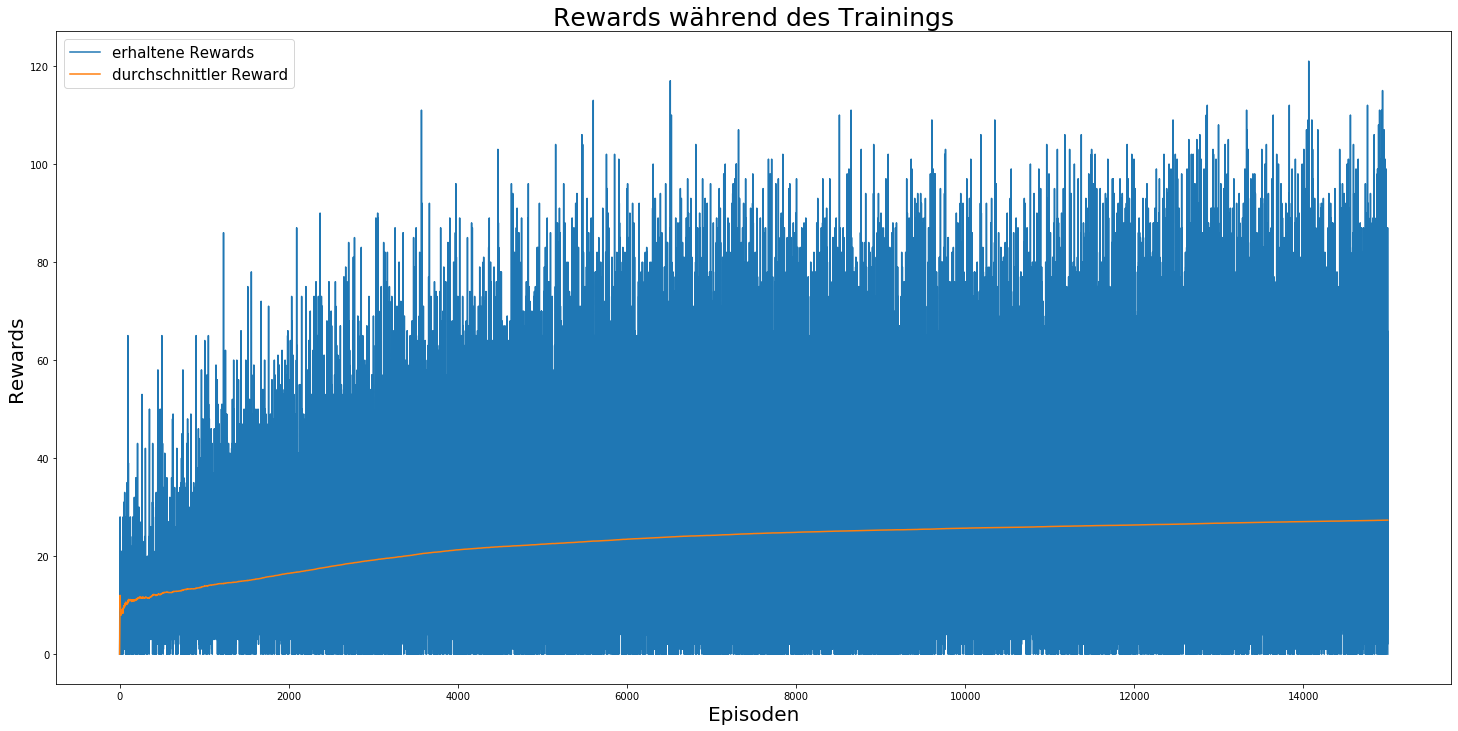

In [24]:
plt.figure(figsize=(25, 12))
plt.plot(REWARD_LIST, label="erhaltene Rewards")
plt.plot(MEAN_LIST, label="durchschnittler Reward")
plt.title("Rewards während des Trainings", fontsize=25)
plt.xlabel("Episoden", fontsize=20)
plt.ylabel("Rewards", fontsize=20)
plt.legend(fontsize=15)
plt.show()

# **Trainierten Agenten spielen lassen**

In [25]:
!ls "WEIGHTS/"

Breakout-v0_DQN_End.h5	    Breakout-v0_DQN_Ep_4641.h5
Breakout-v0_DQN_Ep_1139.h5  MsPacman-v0_DQN_End.h5
Breakout-v0_DQN_Ep_1512.h5  MsPacman-v0_DQN_Ep_13830.h5
Breakout-v0_DQN_Ep_1728.h5  MsPacman-v0_DQN_Ep_1724.h5
Breakout-v0_DQN_Ep_1984.h5  MsPacman-v0_DQN_Ep_4394.h5
Breakout-v0_DQN_Ep_1985.h5  MsPacman-v0_DQN_Ep_6009.h5
Breakout-v0_DQN_Ep_2810.h5


In [26]:
# Gewichte laden
WEIGHTS_PATH = "WEIGHTS/Pong-v0_DQN_Ep_14840.h5"
DQN.load_weights(filepath=WEIGHTS_PATH)

OSError: Unable to open file (unable to open file: name = 'WEIGHTS/Pong-v0_DQN_Ep_14840.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## Rendering a Game

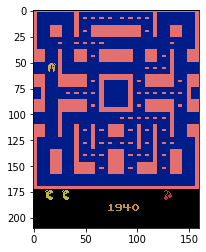

In [27]:
import gym
from IPython import display
import matplotlib
%matplotlib inline

for i in range(1):
    state = env.reset()
    done = False
    while not done:
        img = plt.imshow(env.render(mode='rgb_array'))
        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        action = np.argmax(DQN.predict(state))
        state, reward, done, info = env.step(action)